In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DEAP

In [5]:
!pip install optuna
# !pip install optuna-dashboard

import optuna
from optuna import trial
import itertools
import warnings
import numpy as np
from numpy import savez_compressed
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder                                                      
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from scipy import signal
import pickle as pkl

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.layers import (Activation, AveragePooling1D, Dense, Conv1D, Flatten, Dropout, Input, BatchNormalization,
                                     GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model, to_categorical


warnings.filterwarnings("ignore")
plt.rcdefaults()

# parameters
sampling_rate = 128
window_size = 1280
overlap = 256
channel_len = 32
classes = 2
random_state = 42
labels = ['Low', 'High'] # 0:Low 1:High

''' The frequency bands used: delta (0.5 - 4), theta (4 - 8 Hz), alpha (8 - 14 Hz), beta (14 - 30 Hz), and gamma (30 - 75 Hz) '''
bands = {'delta': [0.5/(sampling_rate/2), 4/(sampling_rate/2)], 'theta': [4/(sampling_rate/2), 8/(sampling_rate/2)], \
         'alpha': [8/(sampling_rate/2), 14/(sampling_rate/2)], 'beta': [14/(sampling_rate/2), 30/(sampling_rate/2)], \
         'gamma': [30/(sampling_rate/2), 75/(sampling_rate/2)]}

subjectList = ['01','02','03', '04','05','06', '07','08','09', '10','11','12', '13','14','15', '16','17','18',
'19','20','21', '22','23','24', '25','26','27', '28','29','30', '31','32']

     |████████████████████████████████| 308 kB 8.8 MB/s 
     |████████████████████████████████| 80 kB 11.1 MB/s 
     |████████████████████████████████| 209 kB 74.4 MB/s 
     |████████████████████████████████| 75 kB 5.2 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 64.4 MB/s 
     |████████████████████████████████| 149 kB 81.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=14e3ab74293c1f53b1cbe8290369517932477b0ac1f4177112d8c928ccb1226c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


##Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Loading Data

###Unzipping

In [ ]:
!unzip /content/drive/MyDrive/data_preprocessed_python.zip

Archive:  /content/drive/MyDrive/data_preprocessed_python.zip
   creating: data_preprocessed_python/
  inflating: data_preprocessed_python/s01.dat  
  inflating: data_preprocessed_python/s02.dat  
  inflating: data_preprocessed_python/s03.dat  
  inflating: data_preprocessed_python/s04.dat  
  inflating: data_preprocessed_python/s05.dat  
  inflating: data_preprocessed_python/s06.dat  
  inflating: data_preprocessed_python/s07.dat  
  inflating: data_preprocessed_python/s08.dat  
  inflating: data_preprocessed_python/s09.dat  
  inflating: data_preprocessed_python/s10.dat  
  inflating: data_preprocessed_python/s11.dat  
  inflating: data_preprocessed_python/s12.dat  
  inflating: data_preprocessed_python/s13.dat  
  inflating: data_preprocessed_python/s14.dat  
  inflating: data_preprocessed_python/s15.dat  
  inflating: data_preprocessed_python/s16.dat  
  inflating: data_preprocessed_python/s17.dat  
  inflating: data_preprocessed_python/s18.dat  
  inflating: data_preprocessed_pyth

###Loading and Pre-processing Deap Dataset

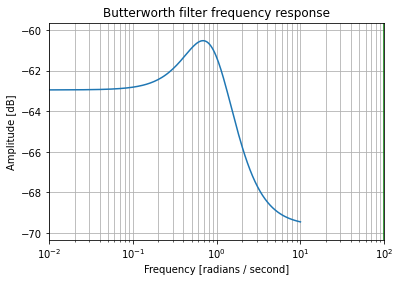

In [ ]:
WN = bands['alpha']
num, den = signal.butter(4, WN, 'band') # Butterworth filter of order N = 4
w, h = signal.freqs(num, den)

plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Butterworth filter frequency response')

plt.xlabel('Frequency [radians / second]')

plt.ylabel('Amplitude [dB]')

plt.margins(0, 0.1)

plt.grid(which='both', axis='both')

plt.axvline(100, color='green') # cutoff frequency

plt.show()

In [ ]:
def load_data(eeg_band = None):

  eeg_signal = []
  valence = []
  arousal = []
  dominance = []
  liking = []

  for subjects in subjectList:

    print('Subject No.' + str(subjects))
    
    address = '/content/data_preprocessed_python/s'+subjects+'.dat'
    
    with open(address, 'rb') as file:
      data = pkl.load(file, encoding = 'latin1')

    eeg = data['data']
    label = data['labels']
    
    # Assigning classes
    label[label<5.5] = 0
    label[label>=5.5] = 1     

    val = label.T[0] # Valence label
    aro = label.T[1] # Arousal label
    dom = label.T[2] # Dominance label
    lik = label.T[3] # Liking label
    del data, label
    

    for i in range(40): # Iterating through 40 vidoes/trials

      sig = eeg[i].T
      v = val[i]
      a = aro[i]
      d = dom[i]
      l = lik[i]

      sig = sig[:, :32] # Considering all 32 EEG channels
      
      num, den = signal.butter(4, bands[eeg_band], 'band') # Butterworth filter of order N = 4
      band_signal = signal.filtfilt(num, den, sig, axis=0)
      sig = band_signal
      del band_signal, num, den
      
      scaler = StandardScaler().fit(sig)
      scaled_sig = scaler.transform(sig)

      del sig
        
      # Segmenting into 10 seconds (1280 timesteps) windows with 2 seconds (256 timesteps) overlap
      start = 0
      while start + window_size < scaled_sig.shape[0]:
        eeg_signal.append(scaled_sig[start:start+window_size, :])

        valence.append(v)
        arousal.append(a)
        dominance.append(d)
        liking.append(l)
        start += overlap

      del scaled_sig


  eeg_signal = np.asarray(eeg_signal, dtype = np.float32)
  valence = np.asarray(valence, dtype = np.int8)
  arousal = np.asarray(arousal, dtype = np.int8)
  dominance = np.asarray(dominance, dtype = np.int8)
  liking = np.asarray(liking, dtype = np.int8)

  print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
  print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)
  print(dominance.shape, dominance[dominance == 0].shape, dominance[dominance == 1].shape)
  print(liking.shape, liking[liking == 0].shape, liking[liking == 1].shape)

  valence = to_categorical(valence)
  arousal = to_categorical(arousal)
  dominance = to_categorical(dominance)
  liking = to_categorical(liking)

    
  return (eeg_signal, valence, arousal, dominance, liking)

In [ ]:
eeg_band = 'alpha'
# eeg_band = 'delta', 'theta', 'alpha', 'beta'

data, valence, arousal, dominance, liking = load_data(eeg_band)

Subject No.01
Subject No.02
Subject No.03
Subject No.04
Subject No.05
Subject No.06
Subject No.07
Subject No.08
Subject No.09
Subject No.10
Subject No.11
Subject No.12
Subject No.13
Subject No.14
Subject No.15
Subject No.16
Subject No.17
Subject No.18
Subject No.19
Subject No.20
Subject No.21
Subject No.22
Subject No.23
Subject No.24
Subject No.25
Subject No.26
Subject No.27
Subject No.28
Subject No.29
Subject No.30
Subject No.31
Subject No.32
(34560,) (18711,) (15849,)
(34560,) (17766,) (16794,)
(34560,) (17739,) (16821,)
(34560,) (13635,) (20925,)


In [ ]:
shuffler = np.random.permutation(data.shape[0])

data = data[shuffler]
valence = valence[shuffler]
arousal = arousal[shuffler]
print('Arousal Label Sample:\n', arousal)
dominance = dominance[shuffler]
liking = liking[shuffler]

Arousal Label Sample:
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


### Saving Data and Labels

In [ ]:
# data
savez_compressed('/content/drive/MyDrive/Data_and_labels/data.npz', data)
#labels
np.save('/content/drive/MyDrive/Data_and_labels/valence',valence)
np.save('/content/drive/MyDrive/Data_and_labels/arousal',arousal)
np.save('/content/drive/MyDrive/Data_and_labels/dominance',dominance)
np.save('/content/drive/MyDrive/Data_and_labels/liking',liking)

NameError: ignored

###Loading Data and Labels

In [ ]:
# data
dict_data = load('/content/drive/MyDrive/Data_and_labels/data.npz')
data = dict_data['arr_0']
print(data.shape)
#labels
valence = np.load('/content/drive/MyDrive/Data_and_labels/valence.npy')
arousal = np.load('/content/drive/MyDrive/Data_and_labels/arousal.npy')
dominance = np.load('/content/drive/MyDrive/Data_and_labels/dominance.npy')
liking = np.load('/content/drive/MyDrive/Data_and_labels/liking.npy')

##HP Tuning


> trial.suggest_categorical('name', choices)

> trial.suggest_float("name", low, high)

> trial.suggest_int('name', low, high, step)

In [ ]:
batch_size = 64
epochs = 10
n_trials=10
train_nb_samples = 5000
test_nb_samples = 500

X_train = X_train[:train_nb_samples]
X_test = X_test[:test_nb_samples]
Y_train = Y_train[:train_nb_samples]
Y_test = Y_test[:test_nb_samples]

###1st Layer (i.e. C1) HPO

In [ ]:
def CompactNet(trial):
    
    X_input = Input(shape = (window_size, channel_len))

    x = Conv1D(
        filters=trial.suggest_categorical('filters', [32, 64, 128]), 
        kernel_size=trial.suggest_categorical('kernel_size', [1, 2]), 
        strides=trial.suggest_categorical('strides', [1, 2]),
        padding = 'same', 
        activation='relu', 
        name='C1')(X_input)


    x = AveragePooling1D(
        pool_size=2,
        # pool_size=trial.suggest_categorical('pool_size', [1, 2]),
        name='AP1')(x)

    x = BatchNormalization(name='BN1')(x)

    x = Conv1D(
        filters=64,
        kernel_size = 5, 
        strides = 2, 
        padding = 'valid', 
        activation='relu', 
        name='C3')(x)


    x = AveragePooling1D(pool_size=2, name='AP2')(x)

    x = BatchNormalization(name='BN2')(x)

    x = Conv1D(
        filters=128,
        kernel_size = 3, 
        strides = 1, 
        padding = 'valid', 
        activation='relu', 
        name='C7')(x)


    x = GlobalAveragePooling1D(name='GAP')(x)

    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)
    # x = Dropout(rate=trial.suggest_float('rate', 0.0, 0.2))(x)

    x = Dense(64)(x)
    x = Activation('tanh')(x)

    x = Dense(8)(x)
    x = Activation('tanh')(x)

    x = Dropout(0.1)(x)
    # x = Dropout(rate=trial.suggest_float('rate', 0.0, 0.1))(x)

    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, decay=1e-5),
              metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):

    model = CompactNet(trial)


    model.fit(
        X_train, Y_train,
        validation_split=0.15,
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Evaluate the model accuracy on the Test set.
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.NSGAIISampler())
# study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)
# study.optimize(objective, n_trials=5)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# print("Training model with best_params {}".format(study.best_params))

[I 2022-01-31 15:23:59,162] A new study created in memory with name: no-name-a899a107-9956-461d-870c-5c9a15b49f54


Epoch 1/10
54/54 [==============================] - 4s 29ms/step - loss: 0.7141 - accuracy: 0.5435 - val_loss: 0.6811 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6836 - accuracy: 0.5638 - val_loss: 0.6810 - val_accuracy: 0.5683
Epoch 3/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6674 - accuracy: 0.5962 - val_loss: 0.6650 - val_accuracy: 0.5900
Epoch 4/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6624 - accuracy: 0.6100 - val_loss: 0.6584 - val_accuracy: 0.6100
Epoch 5/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6460 - accuracy: 0.6171 - val_loss: 0.6857 - val_accuracy: 0.5783
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6463 - accuracy: 0.6235 - val_loss: 0.6736 - val_accuracy: 0.5900
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6328 - accuracy: 0.6362 - val_loss: 0.6686 - val_accuracy: 0.5917
Epoch 8/10
54

[I 2022-01-31 15:24:10,900] Trial 0 finished with value: 0.6039999723434448 and parameters: {'filters': 128, 'kernel_size': 1, 'strides': 2}. Best is trial 0 with value: 0.6039999723434448.


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.7242 - accuracy: 0.5406 - val_loss: 0.6767 - val_accuracy: 0.5833
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6993 - accuracy: 0.5606 - val_loss: 0.6871 - val_accuracy: 0.5717
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6800 - accuracy: 0.5844 - val_loss: 0.6733 - val_accuracy: 0.5900
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6642 - accuracy: 0.5991 - val_loss: 0.6856 - val_accuracy: 0.5850
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6586 - accuracy: 0.6129 - val_loss: 0.6565 - val_accuracy: 0.6050
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6488 - accuracy: 0.6182 - val_loss: 0.6637 - val_accuracy: 0.6000
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6392 - accuracy: 0.6341 - val_loss: 0.6556 - val_accuracy: 0.6000
Epoch 8/10
54

[I 2022-01-31 15:24:20,305] Trial 1 finished with value: 0.6299999952316284 and parameters: {'filters': 32, 'kernel_size': 2, 'strides': 1}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.6977 - accuracy: 0.5318 - val_loss: 0.6799 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.5762 - val_loss: 0.6800 - val_accuracy: 0.5667
Epoch 3/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6659 - accuracy: 0.5956 - val_loss: 0.6782 - val_accuracy: 0.5800
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6590 - accuracy: 0.5994 - val_loss: 0.6777 - val_accuracy: 0.5817
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6519 - accuracy: 0.6059 - val_loss: 0.6663 - val_accuracy: 0.5917
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6480 - accuracy: 0.6209 - val_loss: 0.6568 - val_accuracy: 0.6133
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6414 - accuracy: 0.6288 - val_loss: 0.6514 - val_accuracy: 0.6183
Epoch 8/10
54

[I 2022-01-31 15:24:29,640] Trial 2 finished with value: 0.5920000076293945 and parameters: {'filters': 32, 'kernel_size': 1, 'strides': 1}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7061 - accuracy: 0.5412 - val_loss: 0.6799 - val_accuracy: 0.5950
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6797 - accuracy: 0.5771 - val_loss: 0.6773 - val_accuracy: 0.5983
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6681 - accuracy: 0.5926 - val_loss: 0.6640 - val_accuracy: 0.6083
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6558 - accuracy: 0.6118 - val_loss: 0.6640 - val_accuracy: 0.6167
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6583 - accuracy: 0.6141 - val_loss: 0.6575 - val_accuracy: 0.6100
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6447 - accuracy: 0.6294 - val_loss: 0.6564 - val_accuracy: 0.6150
Epoch 7/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6432 - accuracy: 0.6300 - val_loss: 0.6690 - val_accuracy: 0.5950
Epoch 8/10
54

[I 2022-01-31 15:24:41,989] Trial 3 finished with value: 0.6200000047683716 and parameters: {'filters': 128, 'kernel_size': 1, 'strides': 1}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 2s 18ms/step - loss: 0.7213 - accuracy: 0.5371 - val_loss: 0.6906 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6981 - accuracy: 0.5659 - val_loss: 0.6819 - val_accuracy: 0.5717
Epoch 3/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6833 - accuracy: 0.5785 - val_loss: 0.6797 - val_accuracy: 0.5800
Epoch 4/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6718 - accuracy: 0.5926 - val_loss: 0.6806 - val_accuracy: 0.5700
Epoch 5/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6615 - accuracy: 0.6032 - val_loss: 0.6597 - val_accuracy: 0.6050
Epoch 6/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6542 - accuracy: 0.6203 - val_loss: 0.6679 - val_accuracy: 0.6033
Epoch 7/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6416 - accuracy: 0.6285 - val_loss: 0.6522 - val_accuracy: 0.6183
Epoch 8/10
54

[I 2022-01-31 15:24:51,098] Trial 4 finished with value: 0.6299999952316284 and parameters: {'filters': 32, 'kernel_size': 1, 'strides': 2}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 18ms/step - loss: 0.7305 - accuracy: 0.5356 - val_loss: 0.6843 - val_accuracy: 0.5600
Epoch 2/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6952 - accuracy: 0.5738 - val_loss: 0.6802 - val_accuracy: 0.5633
Epoch 3/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6766 - accuracy: 0.5982 - val_loss: 0.6701 - val_accuracy: 0.5783
Epoch 4/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6607 - accuracy: 0.6050 - val_loss: 0.6580 - val_accuracy: 0.6000
Epoch 5/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6496 - accuracy: 0.6200 - val_loss: 0.6681 - val_accuracy: 0.5850
Epoch 6/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6421 - accuracy: 0.6321 - val_loss: 0.6564 - val_accuracy: 0.6283
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6363 - accuracy: 0.6362 - val_loss: 0.6640 - val_accuracy: 0.6067
Epoch 8/10
54

[I 2022-01-31 15:25:00,772] Trial 5 finished with value: 0.6079999804496765 and parameters: {'filters': 32, 'kernel_size': 2, 'strides': 2}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.7363 - accuracy: 0.5326 - val_loss: 0.6779 - val_accuracy: 0.5733
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6984 - accuracy: 0.5665 - val_loss: 0.6786 - val_accuracy: 0.5867
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6853 - accuracy: 0.5832 - val_loss: 0.6718 - val_accuracy: 0.5883
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6734 - accuracy: 0.5906 - val_loss: 0.6635 - val_accuracy: 0.5767
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6549 - accuracy: 0.6109 - val_loss: 0.6714 - val_accuracy: 0.5550
Epoch 6/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6629 - accuracy: 0.5968 - val_loss: 0.6584 - val_accuracy: 0.5950
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6437 - accuracy: 0.6262 - val_loss: 0.6457 - val_accuracy: 0.6067
Epoch 8/10
54

[I 2022-01-31 15:25:10,066] Trial 6 finished with value: 0.5960000157356262 and parameters: {'filters': 64, 'kernel_size': 1, 'strides': 2}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.6940 - accuracy: 0.5479 - val_loss: 0.6836 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6785 - accuracy: 0.5629 - val_loss: 0.6778 - val_accuracy: 0.5683
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6663 - accuracy: 0.5874 - val_loss: 0.6749 - val_accuracy: 0.5917
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6608 - accuracy: 0.5953 - val_loss: 0.6665 - val_accuracy: 0.6067
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6498 - accuracy: 0.6141 - val_loss: 0.6741 - val_accuracy: 0.5633
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6501 - accuracy: 0.6185 - val_loss: 0.6535 - val_accuracy: 0.6250
Epoch 7/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6359 - accuracy: 0.6335 - val_loss: 0.6601 - val_accuracy: 0.6050
Epoch 8/10
54

[I 2022-01-31 15:25:21,268] Trial 7 finished with value: 0.6140000224113464 and parameters: {'filters': 128, 'kernel_size': 2, 'strides': 1}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.7207 - accuracy: 0.5447 - val_loss: 0.6785 - val_accuracy: 0.5883
Epoch 2/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6901 - accuracy: 0.5479 - val_loss: 0.6744 - val_accuracy: 0.5967
Epoch 3/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6814 - accuracy: 0.5782 - val_loss: 0.6700 - val_accuracy: 0.5850
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6667 - accuracy: 0.6038 - val_loss: 0.6686 - val_accuracy: 0.5900
Epoch 5/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6623 - accuracy: 0.5953 - val_loss: 0.6597 - val_accuracy: 0.6000
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6511 - accuracy: 0.6194 - val_loss: 0.6728 - val_accuracy: 0.5700
Epoch 7/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6439 - accuracy: 0.6200 - val_loss: 0.6587 - val_accuracy: 0.6117
Epoch 8/10
54

[I 2022-01-31 15:25:33,516] Trial 8 finished with value: 0.5920000076293945 and parameters: {'filters': 64, 'kernel_size': 1, 'strides': 1}. Best is trial 1 with value: 0.6299999952316284.


Epoch 1/10
54/54 [==============================] - 3s 20ms/step - loss: 0.7383 - accuracy: 0.5329 - val_loss: 0.6782 - val_accuracy: 0.5867
Epoch 2/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6926 - accuracy: 0.5626 - val_loss: 0.6713 - val_accuracy: 0.5967
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6776 - accuracy: 0.5788 - val_loss: 0.6771 - val_accuracy: 0.5850
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6717 - accuracy: 0.5844 - val_loss: 0.6724 - val_accuracy: 0.5933
Epoch 5/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6647 - accuracy: 0.6006 - val_loss: 0.6603 - val_accuracy: 0.6083
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6562 - accuracy: 0.6071 - val_loss: 0.6619 - val_accuracy: 0.6267
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6441 - accuracy: 0.6265 - val_loss: 0.6533 - val_accuracy: 0.6167
Epoch 8/10
54

[I 2022-01-31 15:25:43,303] Trial 9 finished with value: 0.6140000224113464 and parameters: {'filters': 64, 'kernel_size': 1, 'strides': 1}. Best is trial 1 with value: 0.6299999952316284.


Number of finished trials: 10
Best trial:
  Value: 0.6299999952316284
  Params: 
    filters: 32
    kernel_size: 2
    strides: 1


In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')
trials_df

,number,value,datetime_start,datetime_complete,duration,params_filters,params_kernel_size,params_strides,system_attrs_nsga2:generation,state
0,0,0.604,2022-01-31 15:23:59.166374,2022-01-31 15:24:10.899614,0 days 00:00:11.733240,128,1,2,0,COMPLETE
1,1,0.630,2022-01-31 15:24:10.901591,2022-01-31 15:24:20.305586,0 days 00:00:09.403995,32,2,1,0,COMPLETE
2,2,0.592,2022-01-31 15:24:20.307663,2022-01-31 15:24:29.640089,0 days 00:00:09.332426,32,1,1,0,COMPLETE
3,3,0.620,2022-01-31 15:24:29.642109,2022-01-31 15:24:41.988718,0 days 00:00:12.346609,128,1,1,0,COMPLETE
4,4,0.630,2022-01-31 15:24:41.990650,2022-01-31 15:24:51.097808,0 days 00:00:09.107158,32,1,2,0,COMPLETE
5,5,0.608,2022-01-31 15:24:51.099823,2022-01-31 15:25:00.772449,0 days 00:00:09.672626,32,2,2,0,COMPLETE
6,6,0.596,2022-01-31 15:25:00.774552,2022-01-31 15:25:10.066478,0 days 00:00:09.291926,64,1,2,0,COMPLETE
7,7,0.614,2022-01-31 15:25:10.068517,2022-01-31 15:25:21.268106,0 days 00:00:11.199589,128,2,1,0,COMPLETE
8,8,0.592,2022-01-31 15:25:21.270051,2022-01-31 15:25:33.516575,0 days 00:00:12.246524,64,1,1,0,COMPLETE
9,9,0.614,2022-01-31 15:25:33.518634,2022-01-31 15:25:43.303221,0 days 00:00:09.784587,64,1,1,0,COMPLETE


###2nd Layer (i.e. C3) HPO

In [ ]:
def CompactNet(trial):
    
    X_input = Input(shape = (window_size, channel_len))

    x = Conv1D(32, kernel_size = 2, strides = 1, padding = 'same', activation='relu', name='C1')(X_input)

    x = AveragePooling1D(
        pool_size=2,
        name='AP1')(x)

    x = BatchNormalization(name='BN1')(x)

    x = Conv1D(
        filters=trial.suggest_categorical('filters', [32, 64, 128]), 
        kernel_size=trial.suggest_categorical('kernel_size', [3, 5]), 
        strides=trial.suggest_categorical('strides', [1, 2]),
        padding = 'same', 
        activation='relu', 
        name='C3')(x)


    x = AveragePooling1D(pool_size=2, name='AP2')(x)

    x = BatchNormalization(name='BN2')(x)


    x = Conv1D(
        filters=128,
        kernel_size = 3, 
        strides = 1, 
        padding = 'valid', 
        activation='relu', 
        name='C7')(x)


    x = GlobalAveragePooling1D(name='GAP')(x)

    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)

    x = Dense(64)(x)
    x = Activation('tanh')(x)

    x = Dense(8)(x)
    x = Activation('tanh')(x)

    x = Dropout(0.1)(x)

    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, decay=1e-5),
              metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):

    model = CompactNet(trial)


    model.fit(
        X_train, Y_train,
        validation_split=0.15,
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Evaluate the model accuracy on the Test set.
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.NSGAIISampler())
# study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)
# study.optimize(objective, n_trials=5)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# print("Training model with best_params {}".format(study.best_params))

[I 2022-01-31 15:27:49,165] A new study created in memory with name: no-name-6b85f2b7-f779-4c93-b1b3-8da97285cde9


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.7116 - accuracy: 0.5397 - val_loss: 0.6792 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6803 - accuracy: 0.5835 - val_loss: 0.6783 - val_accuracy: 0.5683
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6613 - accuracy: 0.5985 - val_loss: 0.6773 - val_accuracy: 0.5700
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6620 - accuracy: 0.5994 - val_loss: 0.6802 - val_accuracy: 0.5883
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6559 - accuracy: 0.6074 - val_loss: 0.6649 - val_accuracy: 0.6017
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6447 - accuracy: 0.6218 - val_loss: 0.6515 - val_accuracy: 0.6067
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6495 - accuracy: 0.6191 - val_loss: 0.6560 - val_accuracy: 0.6117
Epoch 8/10
54

[I 2022-01-31 15:27:59,290] Trial 0 finished with value: 0.621999979019165 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 1}. Best is trial 0 with value: 0.621999979019165.


Epoch 1/10
54/54 [==============================] - 2s 18ms/step - loss: 0.7223 - accuracy: 0.5306 - val_loss: 0.6867 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6939 - accuracy: 0.5553 - val_loss: 0.6790 - val_accuracy: 0.5700
Epoch 3/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6770 - accuracy: 0.5862 - val_loss: 0.6729 - val_accuracy: 0.5733
Epoch 4/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6639 - accuracy: 0.6109 - val_loss: 0.6671 - val_accuracy: 0.5983
Epoch 5/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6593 - accuracy: 0.6124 - val_loss: 0.6701 - val_accuracy: 0.6000
Epoch 6/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6525 - accuracy: 0.6103 - val_loss: 0.6746 - val_accuracy: 0.5867
Epoch 7/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6499 - accuracy: 0.6212 - val_loss: 0.6599 - val_accuracy: 0.6117
Epoch 8/10
54

[I 2022-01-31 15:28:08,390] Trial 1 finished with value: 0.593999981880188 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2}. Best is trial 0 with value: 0.621999979019165.


Epoch 1/10
54/54 [==============================] - 3s 18ms/step - loss: 0.7291 - accuracy: 0.5344 - val_loss: 0.6822 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6963 - accuracy: 0.5565 - val_loss: 0.6757 - val_accuracy: 0.5833
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6761 - accuracy: 0.5882 - val_loss: 0.6720 - val_accuracy: 0.5883
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6668 - accuracy: 0.6009 - val_loss: 0.6810 - val_accuracy: 0.5733
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6630 - accuracy: 0.6085 - val_loss: 0.6701 - val_accuracy: 0.5983
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6612 - accuracy: 0.6094 - val_loss: 0.6817 - val_accuracy: 0.5833
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6534 - accuracy: 0.6129 - val_loss: 0.6540 - val_accuracy: 0.6317
Epoch 8/10
54

[I 2022-01-31 15:28:20,671] Trial 2 finished with value: 0.5920000076293945 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 1}. Best is trial 0 with value: 0.621999979019165.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7304 - accuracy: 0.5418 - val_loss: 0.6886 - val_accuracy: 0.5350
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6942 - accuracy: 0.5809 - val_loss: 0.6752 - val_accuracy: 0.5917
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6748 - accuracy: 0.5871 - val_loss: 0.6696 - val_accuracy: 0.5817
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6654 - accuracy: 0.5935 - val_loss: 0.6580 - val_accuracy: 0.6017
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6671 - accuracy: 0.6003 - val_loss: 0.6688 - val_accuracy: 0.5917
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6536 - accuracy: 0.6132 - val_loss: 0.6722 - val_accuracy: 0.5800
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6489 - accuracy: 0.6235 - val_loss: 0.6583 - val_accuracy: 0.5967
Epoch 8/10
54

[I 2022-01-31 15:28:31,166] Trial 3 finished with value: 0.6359999775886536 and parameters: {'filters': 128, 'kernel_size': 5, 'strides': 1}. Best is trial 3 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.7387 - accuracy: 0.5315 - val_loss: 0.6859 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6992 - accuracy: 0.5671 - val_loss: 0.6732 - val_accuracy: 0.5717
Epoch 3/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6820 - accuracy: 0.5776 - val_loss: 0.6762 - val_accuracy: 0.5783
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6693 - accuracy: 0.6018 - val_loss: 0.7010 - val_accuracy: 0.5617
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6543 - accuracy: 0.6150 - val_loss: 0.6770 - val_accuracy: 0.5917
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6515 - accuracy: 0.6200 - val_loss: 0.6478 - val_accuracy: 0.6350
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6420 - accuracy: 0.6324 - val_loss: 0.6510 - val_accuracy: 0.6050
Epoch 8/10
54

[I 2022-01-31 15:28:40,840] Trial 4 finished with value: 0.6019999980926514 and parameters: {'filters': 128, 'kernel_size': 5, 'strides': 2}. Best is trial 3 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 20ms/step - loss: 0.7219 - accuracy: 0.5438 - val_loss: 0.6853 - val_accuracy: 0.5717
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6941 - accuracy: 0.5641 - val_loss: 0.6776 - val_accuracy: 0.5800
Epoch 3/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6841 - accuracy: 0.5721 - val_loss: 0.6728 - val_accuracy: 0.5900
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6753 - accuracy: 0.5865 - val_loss: 0.6679 - val_accuracy: 0.6167
Epoch 5/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6563 - accuracy: 0.6059 - val_loss: 0.6649 - val_accuracy: 0.6100
Epoch 6/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6643 - accuracy: 0.5938 - val_loss: 0.6627 - val_accuracy: 0.5967
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6488 - accuracy: 0.6112 - val_loss: 0.6501 - val_accuracy: 0.6150
Epoch 8/10
54

[I 2022-01-31 15:28:50,649] Trial 5 finished with value: 0.6140000224113464 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1}. Best is trial 3 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.8182 - accuracy: 0.5409 - val_loss: 0.6894 - val_accuracy: 0.5483
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7447 - accuracy: 0.5618 - val_loss: 0.7129 - val_accuracy: 0.5700
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7270 - accuracy: 0.5688 - val_loss: 0.6874 - val_accuracy: 0.5867
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 0.7140 - accuracy: 0.5779 - val_loss: 0.6864 - val_accuracy: 0.5833
Epoch 5/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6895 - accuracy: 0.5918 - val_loss: 0.6678 - val_accuracy: 0.6067
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6693 - accuracy: 0.6171 - val_loss: 0.6655 - val_accuracy: 0.5950
Epoch 7/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6732 - accuracy: 0.6044 - val_loss: 0.6585 - val_accuracy: 0.6050
Epoch 8/10
54

[I 2022-01-31 15:29:01,792] Trial 6 finished with value: 0.5740000009536743 and parameters: {'filters': 128, 'kernel_size': 3, 'strides': 1}. Best is trial 3 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7122 - accuracy: 0.5591 - val_loss: 0.6765 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6815 - accuracy: 0.5782 - val_loss: 0.6831 - val_accuracy: 0.5683
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6719 - accuracy: 0.5894 - val_loss: 0.6676 - val_accuracy: 0.5900
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6647 - accuracy: 0.5924 - val_loss: 0.6547 - val_accuracy: 0.6083
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6578 - accuracy: 0.6115 - val_loss: 0.6474 - val_accuracy: 0.5983
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6522 - accuracy: 0.6138 - val_loss: 0.6608 - val_accuracy: 0.5900
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6525 - accuracy: 0.6076 - val_loss: 0.6606 - val_accuracy: 0.6033
Epoch 8/10
54

[I 2022-01-31 15:29:12,262] Trial 7 finished with value: 0.6179999709129333 and parameters: {'filters': 128, 'kernel_size': 5, 'strides': 1}. Best is trial 3 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 19ms/step - loss: 0.7329 - accuracy: 0.5432 - val_loss: 0.6770 - val_accuracy: 0.5917
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6940 - accuracy: 0.5615 - val_loss: 0.6747 - val_accuracy: 0.5750
Epoch 3/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6659 - accuracy: 0.6088 - val_loss: 0.6677 - val_accuracy: 0.5883
Epoch 4/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.5824 - val_loss: 0.6573 - val_accuracy: 0.6067
Epoch 5/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6558 - accuracy: 0.6047 - val_loss: 0.6579 - val_accuracy: 0.5967
Epoch 6/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6474 - accuracy: 0.6265 - val_loss: 0.6594 - val_accuracy: 0.5983
Epoch 7/10
54/54 [==============================] - 1s 13ms/step - loss: 0.6501 - accuracy: 0.6191 - val_loss: 0.6451 - val_accuracy: 0.6317
Epoch 8/10
54

[I 2022-01-31 15:29:24,521] Trial 8 finished with value: 0.6039999723434448 and parameters: {'filters': 128, 'kernel_size': 5, 'strides': 2}. Best is trial 3 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 2s 19ms/step - loss: 0.7136 - accuracy: 0.5400 - val_loss: 0.6786 - val_accuracy: 0.5700
Epoch 2/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6892 - accuracy: 0.5644 - val_loss: 0.6790 - val_accuracy: 0.5683
Epoch 3/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6721 - accuracy: 0.5879 - val_loss: 0.6711 - val_accuracy: 0.5950
Epoch 4/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6642 - accuracy: 0.6003 - val_loss: 0.6709 - val_accuracy: 0.5817
Epoch 5/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6595 - accuracy: 0.6074 - val_loss: 0.6862 - val_accuracy: 0.5550
Epoch 6/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6534 - accuracy: 0.6062 - val_loss: 0.6589 - val_accuracy: 0.6050
Epoch 7/10
54/54 [==============================] - 1s 12ms/step - loss: 0.6439 - accuracy: 0.6244 - val_loss: 0.6689 - val_accuracy: 0.6017
Epoch 8/10
54

[I 2022-01-31 15:29:33,591] Trial 9 finished with value: 0.6359999775886536 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 2}. Best is trial 3 with value: 0.6359999775886536.


Number of finished trials: 10
Best trial:
  Value: 0.6359999775886536
  Params: 
    filters: 128
    kernel_size: 5
    strides: 1


In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')
trials_df

,number,value,datetime_start,datetime_complete,duration,params_filters,params_kernel_size,params_strides,system_attrs_nsga2:generation,state
0,0,0.622,2022-01-31 15:27:49.167252,2022-01-31 15:27:59.290263,0 days 00:00:10.123011,32,5,1,0,COMPLETE
1,1,0.594,2022-01-31 15:27:59.293192,2022-01-31 15:28:08.390089,0 days 00:00:09.096897,32,5,2,0,COMPLETE
2,2,0.592,2022-01-31 15:28:08.392082,2022-01-31 15:28:20.671043,0 days 00:00:12.278961,32,5,1,0,COMPLETE
3,3,0.636,2022-01-31 15:28:20.673299,2022-01-31 15:28:31.165562,0 days 00:00:10.492263,128,5,1,0,COMPLETE
4,4,0.602,2022-01-31 15:28:31.167509,2022-01-31 15:28:40.839635,0 days 00:00:09.672126,128,5,2,0,COMPLETE
5,5,0.614,2022-01-31 15:28:40.841637,2022-01-31 15:28:50.648688,0 days 00:00:09.807051,64,5,1,0,COMPLETE
6,6,0.574,2022-01-31 15:28:50.650648,2022-01-31 15:29:01.791999,0 days 00:00:11.141351,128,3,1,0,COMPLETE
7,7,0.618,2022-01-31 15:29:01.793844,2022-01-31 15:29:12.261677,0 days 00:00:10.467833,128,5,1,0,COMPLETE
8,8,0.604,2022-01-31 15:29:12.263728,2022-01-31 15:29:24.521509,0 days 00:00:12.257781,128,5,2,0,COMPLETE
9,9,0.636,2022-01-31 15:29:24.523499,2022-01-31 15:29:33.590696,0 days 00:00:09.067197,64,3,2,0,COMPLETE


###3rd Layer (i.e. C7) HPO

In [ ]:
def CompactNet(trial):
    
    X_input = Input(shape = (window_size, channel_len))

    x = Conv1D(32, kernel_size = 2, strides = 1, padding = 'same', activation='relu', name='C1')(X_input)

    x = AveragePooling1D(
        pool_size=2,
        name='AP1')(x)

    x = BatchNormalization(name='BN1')(x)

    x = Conv1D(128, kernel_size = 5, strides = 1, padding = 'same', activation='relu', name='C3')(x)

    x = AveragePooling1D(pool_size=2, name='AP2')(x)

    x = BatchNormalization(name='BN2')(x)

    x = Conv1D(
        filters=trial.suggest_categorical('filters', [128, 192, 256]), 
        kernel_size=trial.suggest_categorical('kernel_size', [3, 5]), 
        strides=trial.suggest_categorical('strides', [1, 2]),
        padding = 'same', 
        activation='relu', 
        name='C7')(x)


    x = GlobalAveragePooling1D(name='GAP')(x)

    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)


    x = Dense(64)(x)
    x = Activation('tanh')(x)

    x = Dense(8)(x)
    x = Activation('tanh')(x)

    x = Dropout(0.1)(x)

    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, decay=1e-5),
              metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):

    model = CompactNet(trial)


    model.fit(
        X_train, Y_train,
        validation_split=0.15,
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Evaluate the model accuracy on the Test set.
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.NSGAIISampler())
# study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)
# study.optimize(objective, n_trials=5)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# print("Training model with best_params {}".format(study.best_params))

[I 2022-01-31 15:35:54,102] A new study created in memory with name: no-name-b6016e5e-f2e9-492d-aba3-052521b21e79


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7598 - accuracy: 0.5318 - val_loss: 0.6983 - val_accuracy: 0.4733
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.7109 - accuracy: 0.5615 - val_loss: 0.6790 - val_accuracy: 0.5667
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6907 - accuracy: 0.5776 - val_loss: 0.6812 - val_accuracy: 0.5483
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6873 - accuracy: 0.5897 - val_loss: 0.6535 - val_accuracy: 0.6350
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6829 - accuracy: 0.5800 - val_loss: 0.6565 - val_accuracy: 0.5900
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6596 - accuracy: 0.6147 - val_loss: 0.6838 - val_accuracy: 0.5717
Epoch 7/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6611 - accuracy: 0.6071 - val_loss: 0.6707 - val_accuracy: 0.6017
Epoch 8/10
54

[I 2022-01-31 15:36:05,517] Trial 0 finished with value: 0.5920000076293945 and parameters: {'filters': 192, 'kernel_size': 5, 'strides': 1}. Best is trial 0 with value: 0.5920000076293945.


Epoch 1/10
54/54 [==============================] - 3s 30ms/step - loss: 0.8100 - accuracy: 0.5347 - val_loss: 0.6793 - val_accuracy: 0.5800
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7325 - accuracy: 0.5744 - val_loss: 0.6741 - val_accuracy: 0.5767
Epoch 3/10
54/54 [==============================] - 1s 14ms/step - loss: 0.7218 - accuracy: 0.5824 - val_loss: 0.6602 - val_accuracy: 0.6050
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7031 - accuracy: 0.5756 - val_loss: 0.6594 - val_accuracy: 0.5967
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6890 - accuracy: 0.5935 - val_loss: 0.6690 - val_accuracy: 0.6033
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6763 - accuracy: 0.6015 - val_loss: 0.6669 - val_accuracy: 0.5867
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6585 - accuracy: 0.6276 - val_loss: 0.6565 - val_accuracy: 0.6133
Epoch 8/10
54

[I 2022-01-31 15:36:16,355] Trial 1 finished with value: 0.6359999775886536 and parameters: {'filters': 192, 'kernel_size': 3, 'strides': 2}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 20ms/step - loss: 0.7382 - accuracy: 0.5353 - val_loss: 0.6769 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6988 - accuracy: 0.5659 - val_loss: 0.6844 - val_accuracy: 0.5733
Epoch 3/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6888 - accuracy: 0.5697 - val_loss: 0.6838 - val_accuracy: 0.5817
Epoch 4/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6708 - accuracy: 0.6015 - val_loss: 0.6739 - val_accuracy: 0.5767
Epoch 5/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6645 - accuracy: 0.6115 - val_loss: 0.6625 - val_accuracy: 0.6050
Epoch 6/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6671 - accuracy: 0.5979 - val_loss: 0.6747 - val_accuracy: 0.5483
Epoch 7/10
54/54 [==============================] - 1s 14ms/step - loss: 0.6528 - accuracy: 0.6150 - val_loss: 0.6495 - val_accuracy: 0.6000
Epoch 8/10
54

[I 2022-01-31 15:36:28,587] Trial 2 finished with value: 0.6079999804496765 and parameters: {'filters': 128, 'kernel_size': 3, 'strides': 2}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7665 - accuracy: 0.5265 - val_loss: 0.6827 - val_accuracy: 0.5700
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.7048 - accuracy: 0.5674 - val_loss: 0.6752 - val_accuracy: 0.5950
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6969 - accuracy: 0.5700 - val_loss: 0.6652 - val_accuracy: 0.5900
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6820 - accuracy: 0.5832 - val_loss: 0.6617 - val_accuracy: 0.6050
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6639 - accuracy: 0.6015 - val_loss: 0.6636 - val_accuracy: 0.5967
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6682 - accuracy: 0.6026 - val_loss: 0.6559 - val_accuracy: 0.6167
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6476 - accuracy: 0.6129 - val_loss: 0.6615 - val_accuracy: 0.6183
Epoch 8/10
54

[I 2022-01-31 15:36:39,409] Trial 3 finished with value: 0.5879999995231628 and parameters: {'filters': 256, 'kernel_size': 3, 'strides': 1}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7259 - accuracy: 0.5279 - val_loss: 0.6846 - val_accuracy: 0.5550
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6787 - accuracy: 0.5853 - val_loss: 0.6808 - val_accuracy: 0.5800
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6704 - accuracy: 0.5876 - val_loss: 0.6708 - val_accuracy: 0.5917
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6610 - accuracy: 0.6041 - val_loss: 0.6618 - val_accuracy: 0.6150
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6578 - accuracy: 0.6076 - val_loss: 0.6679 - val_accuracy: 0.6100
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6411 - accuracy: 0.6321 - val_loss: 0.6679 - val_accuracy: 0.5800
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6454 - accuracy: 0.6212 - val_loss: 0.6603 - val_accuracy: 0.5933
Epoch 8/10
54

[I 2022-01-31 15:36:51,618] Trial 4 finished with value: 0.6000000238418579 and parameters: {'filters': 192, 'kernel_size': 3, 'strides': 1}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7519 - accuracy: 0.5288 - val_loss: 0.7058 - val_accuracy: 0.5267
Epoch 2/10
54/54 [==============================] - 1s 17ms/step - loss: 0.7169 - accuracy: 0.5544 - val_loss: 0.6913 - val_accuracy: 0.5267
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.7054 - accuracy: 0.5659 - val_loss: 0.6704 - val_accuracy: 0.5883
Epoch 4/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6900 - accuracy: 0.5874 - val_loss: 0.6626 - val_accuracy: 0.6183
Epoch 5/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6815 - accuracy: 0.5994 - val_loss: 0.6730 - val_accuracy: 0.5983
Epoch 6/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6785 - accuracy: 0.5921 - val_loss: 0.7028 - val_accuracy: 0.5383
Epoch 7/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6742 - accuracy: 0.6082 - val_loss: 0.6691 - val_accuracy: 0.5767
Epoch 8/10
54

[I 2022-01-31 15:37:03,002] Trial 5 finished with value: 0.6140000224113464 and parameters: {'filters': 256, 'kernel_size': 5, 'strides': 1}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7560 - accuracy: 0.5424 - val_loss: 0.6843 - val_accuracy: 0.5700
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.7086 - accuracy: 0.5641 - val_loss: 0.6925 - val_accuracy: 0.5133
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5762 - val_loss: 0.6745 - val_accuracy: 0.5833
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6871 - accuracy: 0.5821 - val_loss: 0.6694 - val_accuracy: 0.5983
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6669 - accuracy: 0.6059 - val_loss: 0.6538 - val_accuracy: 0.6250
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6693 - accuracy: 0.6029 - val_loss: 0.6783 - val_accuracy: 0.5917
Epoch 7/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6650 - accuracy: 0.6150 - val_loss: 0.6631 - val_accuracy: 0.6033
Epoch 8/10
54

[I 2022-01-31 15:37:13,939] Trial 6 finished with value: 0.6079999804496765 and parameters: {'filters': 256, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7646 - accuracy: 0.5262 - val_loss: 0.6863 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7155 - accuracy: 0.5574 - val_loss: 0.6819 - val_accuracy: 0.5800
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6914 - accuracy: 0.5776 - val_loss: 0.6864 - val_accuracy: 0.5650
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6810 - accuracy: 0.5912 - val_loss: 0.6667 - val_accuracy: 0.6000
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6770 - accuracy: 0.5921 - val_loss: 0.6641 - val_accuracy: 0.6117
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6580 - accuracy: 0.6065 - val_loss: 0.6465 - val_accuracy: 0.6150
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6548 - accuracy: 0.6129 - val_loss: 0.6562 - val_accuracy: 0.5950
Epoch 8/10
54

[I 2022-01-31 15:37:25,234] Trial 7 finished with value: 0.5899999737739563 and parameters: {'filters': 128, 'kernel_size': 5, 'strides': 1}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7399 - accuracy: 0.5376 - val_loss: 0.6825 - val_accuracy: 0.5883
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7056 - accuracy: 0.5491 - val_loss: 0.6829 - val_accuracy: 0.5617
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6956 - accuracy: 0.5656 - val_loss: 0.6719 - val_accuracy: 0.5867
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6805 - accuracy: 0.5782 - val_loss: 0.6640 - val_accuracy: 0.5783
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6757 - accuracy: 0.5894 - val_loss: 0.6667 - val_accuracy: 0.5850
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6666 - accuracy: 0.6044 - val_loss: 0.6782 - val_accuracy: 0.5700
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6412 - accuracy: 0.6209 - val_loss: 0.6590 - val_accuracy: 0.6133
Epoch 8/10
54

[I 2022-01-31 15:37:36,049] Trial 8 finished with value: 0.5879999995231628 and parameters: {'filters': 192, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: 0.6359999775886536.


Epoch 1/10
54/54 [==============================] - 3s 22ms/step - loss: 0.7514 - accuracy: 0.5306 - val_loss: 0.6829 - val_accuracy: 0.5717
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6996 - accuracy: 0.5671 - val_loss: 0.6845 - val_accuracy: 0.5683
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6781 - accuracy: 0.5829 - val_loss: 0.6782 - val_accuracy: 0.5683
Epoch 4/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6753 - accuracy: 0.5874 - val_loss: 0.6697 - val_accuracy: 0.6000
Epoch 5/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6675 - accuracy: 0.5888 - val_loss: 0.6595 - val_accuracy: 0.6217
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6473 - accuracy: 0.6209 - val_loss: 0.6563 - val_accuracy: 0.6067
Epoch 7/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6431 - accuracy: 0.6226 - val_loss: 0.6620 - val_accuracy: 0.5967
Epoch 8/10
54

[I 2022-01-31 15:37:47,004] Trial 9 finished with value: 0.5699999928474426 and parameters: {'filters': 256, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: 0.6359999775886536.


Number of finished trials: 10
Best trial:
  Value: 0.6359999775886536
  Params: 
    filters: 192
    kernel_size: 3
    strides: 2


In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')
trials_df

,number,value,datetime_start,datetime_complete,duration,params_filters,params_kernel_size,params_strides,system_attrs_nsga2:generation,state
0,0,0.592,2022-01-31 15:35:54.105254,2022-01-31 15:36:05.516607,0 days 00:00:11.411353,192,5,1,0,COMPLETE
1,1,0.636,2022-01-31 15:36:05.518481,2022-01-31 15:36:16.355305,0 days 00:00:10.836824,192,3,2,0,COMPLETE
2,2,0.608,2022-01-31 15:36:16.357264,2022-01-31 15:36:28.587369,0 days 00:00:12.230105,128,3,2,0,COMPLETE
3,3,0.588,2022-01-31 15:36:28.589312,2022-01-31 15:36:39.409534,0 days 00:00:10.820222,256,3,1,0,COMPLETE
4,4,0.600,2022-01-31 15:36:39.411421,2022-01-31 15:36:51.618265,0 days 00:00:12.206844,192,3,1,0,COMPLETE
5,5,0.614,2022-01-31 15:36:51.620767,2022-01-31 15:37:03.002131,0 days 00:00:11.381364,256,5,1,0,COMPLETE
6,6,0.608,2022-01-31 15:37:03.003994,2022-01-31 15:37:13.939326,0 days 00:00:10.935332,256,5,2,0,COMPLETE
7,7,0.590,2022-01-31 15:37:13.941499,2022-01-31 15:37:25.233716,0 days 00:00:11.292217,128,5,1,0,COMPLETE
8,8,0.588,2022-01-31 15:37:25.235779,2022-01-31 15:37:36.048997,0 days 00:00:10.813218,192,5,2,0,COMPLETE
9,9,0.570,2022-01-31 15:37:36.050893,2022-01-31 15:37:47.004214,0 days 00:00:10.953321,256,5,2,0,COMPLETE


###4th Layer (i.e. Dense1) HPO

In [ ]:
def CompactNet(trial):
    
    X_input = Input(shape = (window_size, channel_len))

    x = Conv1D(32, kernel_size = 2, strides = 1, padding = 'same', activation='relu', name='C1')(X_input)

    x = AveragePooling1D(
        pool_size=2,
        name='AP1')(x)

    x = BatchNormalization(name='BN1')(x)

    x = Conv1D(128, kernel_size = 5, strides = 1, padding = 'same', activation='relu', name='C3')(x)

    x = AveragePooling1D(pool_size=2, name='AP2')(x)

    x = BatchNormalization(name='BN2')(x)

    x = Conv1D(192, kernel_size = 3, strides = 2, padding = 'same', activation='relu', name='C7')(x)

    x = GlobalAveragePooling1D(name='GAP')(x)

    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)

    x = Dense(
        units=trial.suggest_int('units', 64, 128, 256),
        activation=trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])
        )(x)

    x = Dense(8)(x)
    x = Activation('tanh')(x)


    x = Dropout(0.1)(x)

    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, decay=1e-5),
              metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):

    model = CompactNet(trial)


    model.fit(
        X_train, Y_train,
        validation_split=0.15,
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Evaluate the model accuracy on the Test set.
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.NSGAIISampler())

study.optimize(objective, n_trials=n_trials)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# print("Training model with best_params {}".format(study.best_params))

[I 2022-01-31 15:53:57,810] A new study created in memory with name: no-name-50e5a3d8-2b5f-4bb1-97ab-c225d923b117


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7660 - accuracy: 0.5368 - val_loss: 0.6841 - val_accuracy: 0.5750
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7103 - accuracy: 0.5676 - val_loss: 0.6791 - val_accuracy: 0.5700
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7004 - accuracy: 0.5729 - val_loss: 0.6726 - val_accuracy: 0.5800
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6747 - accuracy: 0.6053 - val_loss: 0.6667 - val_accuracy: 0.6083
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6746 - accuracy: 0.6062 - val_loss: 0.6594 - val_accuracy: 0.5983
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6691 - accuracy: 0.6006 - val_loss: 0.6785 - val_accuracy: 0.5867
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6729 - accuracy: 0.5962 - val_loss: 0.6632 - val_accuracy: 0.6183
Epoch 8/10
54

[I 2022-01-31 15:54:08,999] Trial 0 finished with value: 0.578000009059906 and parameters: {'units': 64, 'activation': 'relu'}. Best is trial 0 with value: 0.578000009059906.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7504 - accuracy: 0.5262 - val_loss: 0.6864 - val_accuracy: 0.5617
Epoch 2/10
54/54 [==============================] - 1s 16ms/step - loss: 0.7045 - accuracy: 0.5618 - val_loss: 0.6738 - val_accuracy: 0.5983
Epoch 3/10
54/54 [==============================] - 1s 19ms/step - loss: 0.6880 - accuracy: 0.5726 - val_loss: 0.6724 - val_accuracy: 0.5800
Epoch 4/10
54/54 [==============================] - 1s 21ms/step - loss: 0.6661 - accuracy: 0.6129 - val_loss: 0.6635 - val_accuracy: 0.5850
Epoch 5/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6679 - accuracy: 0.6000 - val_loss: 0.6575 - val_accuracy: 0.6050
Epoch 6/10
54/54 [==============================] - 1s 21ms/step - loss: 0.6557 - accuracy: 0.6035 - val_loss: 0.6623 - val_accuracy: 0.5883
Epoch 7/10
54/54 [==============================] - 1s 19ms/step - loss: 0.6341 - accuracy: 0.6391 - val_loss: 0.6701 - val_accuracy: 0.6067
Epoch 8/10
54

[I 2022-01-31 15:54:21,645] Trial 1 finished with value: 0.6179999709129333 and parameters: {'units': 64, 'activation': 'tanh'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 28ms/step - loss: 0.7882 - accuracy: 0.5382 - val_loss: 0.6926 - val_accuracy: 0.5217
Epoch 2/10
54/54 [==============================] - 1s 19ms/step - loss: 0.7378 - accuracy: 0.5524 - val_loss: 0.6818 - val_accuracy: 0.5850
Epoch 3/10
54/54 [==============================] - 1s 19ms/step - loss: 0.7110 - accuracy: 0.5785 - val_loss: 0.6737 - val_accuracy: 0.5800
Epoch 4/10
54/54 [==============================] - 1s 20ms/step - loss: 0.7003 - accuracy: 0.5785 - val_loss: 0.6726 - val_accuracy: 0.5800
Epoch 5/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6829 - accuracy: 0.5950 - val_loss: 0.6638 - val_accuracy: 0.5850
Epoch 6/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6775 - accuracy: 0.5871 - val_loss: 0.6775 - val_accuracy: 0.5950
Epoch 7/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6809 - accuracy: 0.5897 - val_loss: 0.6615 - val_accuracy: 0.6000
Epoch 8/10
54

[I 2022-01-31 15:54:34,349] Trial 2 finished with value: 0.593999981880188 and parameters: {'units': 64, 'activation': 'relu'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7302 - accuracy: 0.5388 - val_loss: 0.6789 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6812 - accuracy: 0.5847 - val_loss: 0.6787 - val_accuracy: 0.5700
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6677 - accuracy: 0.5935 - val_loss: 0.6759 - val_accuracy: 0.5817
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6663 - accuracy: 0.6006 - val_loss: 0.6765 - val_accuracy: 0.5800
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6528 - accuracy: 0.6076 - val_loss: 0.6716 - val_accuracy: 0.6017
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6511 - accuracy: 0.6171 - val_loss: 0.6564 - val_accuracy: 0.5933
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6412 - accuracy: 0.6306 - val_loss: 0.6545 - val_accuracy: 0.5983
Epoch 8/10
54

[I 2022-01-31 15:54:44,992] Trial 3 finished with value: 0.5960000157356262 and parameters: {'units': 64, 'activation': 'tanh'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 25ms/step - loss: 0.7995 - accuracy: 0.5388 - val_loss: 0.6987 - val_accuracy: 0.5100
Epoch 2/10
54/54 [==============================] - 1s 20ms/step - loss: 0.7316 - accuracy: 0.5638 - val_loss: 0.6782 - val_accuracy: 0.5650
Epoch 3/10
54/54 [==============================] - 1s 18ms/step - loss: 0.7081 - accuracy: 0.5776 - val_loss: 0.6673 - val_accuracy: 0.6117
Epoch 4/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6978 - accuracy: 0.5900 - val_loss: 0.6689 - val_accuracy: 0.6000
Epoch 5/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6994 - accuracy: 0.5788 - val_loss: 0.6594 - val_accuracy: 0.6200
Epoch 6/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6729 - accuracy: 0.6047 - val_loss: 0.6514 - val_accuracy: 0.6150
Epoch 7/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6648 - accuracy: 0.6047 - val_loss: 0.6665 - val_accuracy: 0.5950
Epoch 8/10
54

[I 2022-01-31 15:54:57,596] Trial 4 finished with value: 0.550000011920929 and parameters: {'units': 64, 'activation': 'relu'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 23ms/step - loss: 0.7594 - accuracy: 0.5368 - val_loss: 0.6818 - val_accuracy: 0.5833
Epoch 2/10
54/54 [==============================] - 1s 18ms/step - loss: 0.7268 - accuracy: 0.5429 - val_loss: 0.6809 - val_accuracy: 0.5933
Epoch 3/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6957 - accuracy: 0.5715 - val_loss: 0.6765 - val_accuracy: 0.5817
Epoch 4/10
54/54 [==============================] - 1s 17ms/step - loss: 0.7036 - accuracy: 0.5688 - val_loss: 0.6807 - val_accuracy: 0.5750
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6952 - accuracy: 0.5579 - val_loss: 0.6865 - val_accuracy: 0.5517
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6843 - accuracy: 0.5756 - val_loss: 0.6705 - val_accuracy: 0.5900
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6767 - accuracy: 0.5841 - val_loss: 0.6712 - val_accuracy: 0.6033
Epoch 8/10
54

[I 2022-01-31 15:55:09,527] Trial 5 finished with value: 0.5960000157356262 and parameters: {'units': 64, 'activation': 'linear'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7338 - accuracy: 0.5512 - val_loss: 0.6989 - val_accuracy: 0.4683
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7032 - accuracy: 0.5641 - val_loss: 0.6824 - val_accuracy: 0.5550
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6865 - accuracy: 0.5838 - val_loss: 0.6785 - val_accuracy: 0.5717
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6777 - accuracy: 0.5906 - val_loss: 0.6663 - val_accuracy: 0.5917
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6701 - accuracy: 0.6003 - val_loss: 0.6660 - val_accuracy: 0.5933
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6588 - accuracy: 0.6012 - val_loss: 0.6579 - val_accuracy: 0.5900
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6372 - accuracy: 0.6379 - val_loss: 0.6508 - val_accuracy: 0.6150
Epoch 8/10
54

[I 2022-01-31 15:55:21,689] Trial 6 finished with value: 0.6159999966621399 and parameters: {'units': 64, 'activation': 'relu'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 24ms/step - loss: 0.7727 - accuracy: 0.5238 - val_loss: 0.6791 - val_accuracy: 0.5667
Epoch 2/10
54/54 [==============================] - 1s 20ms/step - loss: 0.7232 - accuracy: 0.5394 - val_loss: 0.6876 - val_accuracy: 0.5517
Epoch 3/10
54/54 [==============================] - 1s 18ms/step - loss: 0.7160 - accuracy: 0.5565 - val_loss: 0.7023 - val_accuracy: 0.5617
Epoch 4/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6997 - accuracy: 0.5547 - val_loss: 0.6636 - val_accuracy: 0.5833
Epoch 5/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6968 - accuracy: 0.5597 - val_loss: 0.6750 - val_accuracy: 0.5783
Epoch 6/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6850 - accuracy: 0.5688 - val_loss: 0.6789 - val_accuracy: 0.5817
Epoch 7/10
54/54 [==============================] - 1s 19ms/step - loss: 0.6703 - accuracy: 0.5791 - val_loss: 0.6669 - val_accuracy: 0.5700
Epoch 8/10
54

[I 2022-01-31 15:55:44,358] Trial 7 finished with value: 0.6079999804496765 and parameters: {'units': 64, 'activation': 'linear'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7857 - accuracy: 0.5276 - val_loss: 0.6907 - val_accuracy: 0.5167
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7280 - accuracy: 0.5459 - val_loss: 0.6819 - val_accuracy: 0.5633
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7085 - accuracy: 0.5688 - val_loss: 0.6817 - val_accuracy: 0.5717
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6967 - accuracy: 0.5674 - val_loss: 0.6669 - val_accuracy: 0.5800
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6844 - accuracy: 0.5791 - val_loss: 0.6911 - val_accuracy: 0.5517
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6885 - accuracy: 0.5826 - val_loss: 0.6744 - val_accuracy: 0.5600
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6805 - accuracy: 0.5835 - val_loss: 0.6882 - val_accuracy: 0.5750
Epoch 8/10
54

[I 2022-01-31 15:55:54,787] Trial 8 finished with value: 0.5920000076293945 and parameters: {'units': 64, 'activation': 'linear'}. Best is trial 1 with value: 0.6179999709129333.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7247 - accuracy: 0.5368 - val_loss: 0.6789 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6902 - accuracy: 0.5635 - val_loss: 0.6830 - val_accuracy: 0.5467
Epoch 3/10
54/54 [==============================] - 1s 20ms/step - loss: 0.6760 - accuracy: 0.5856 - val_loss: 0.6761 - val_accuracy: 0.5617
Epoch 4/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6652 - accuracy: 0.5997 - val_loss: 0.6664 - val_accuracy: 0.5933
Epoch 5/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6516 - accuracy: 0.6150 - val_loss: 0.6719 - val_accuracy: 0.5867
Epoch 6/10
54/54 [==============================] - 1s 21ms/step - loss: 0.6435 - accuracy: 0.6276 - val_loss: 0.6590 - val_accuracy: 0.5933
Epoch 7/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6397 - accuracy: 0.6297 - val_loss: 0.6456 - val_accuracy: 0.6267
Epoch 8/10
54

[I 2022-01-31 15:56:07,213] Trial 9 finished with value: 0.5979999899864197 and parameters: {'units': 64, 'activation': 'tanh'}. Best is trial 1 with value: 0.6179999709129333.


Number of finished trials: 10
Best trial:
  Value: 0.6179999709129333
  Params: 
    units: 64
    activation: tanh


In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')
trials_df

,number,value,datetime_start,datetime_complete,duration,params_activation,params_units,system_attrs_nsga2:generation,state
0,0,0.578,2022-01-31 15:53:57.812575,2022-01-31 15:54:08.999073,0 days 00:00:11.186498,relu,64,0,COMPLETE
1,1,0.618,2022-01-31 15:54:09.000950,2022-01-31 15:54:21.645456,0 days 00:00:12.644506,tanh,64,0,COMPLETE
2,2,0.594,2022-01-31 15:54:21.647251,2022-01-31 15:54:34.348509,0 days 00:00:12.701258,relu,64,0,COMPLETE
3,3,0.596,2022-01-31 15:54:34.350645,2022-01-31 15:54:44.991525,0 days 00:00:10.640880,tanh,64,0,COMPLETE
4,4,0.550,2022-01-31 15:54:44.993730,2022-01-31 15:54:57.595559,0 days 00:00:12.601829,relu,64,0,COMPLETE
5,5,0.596,2022-01-31 15:54:57.598730,2022-01-31 15:55:09.526917,0 days 00:00:11.928187,linear,64,0,COMPLETE
6,6,0.616,2022-01-31 15:55:09.528674,2022-01-31 15:55:21.688604,0 days 00:00:12.159930,relu,64,0,COMPLETE
7,7,0.608,2022-01-31 15:55:21.690658,2022-01-31 15:55:44.357814,0 days 00:00:22.667156,linear,64,0,COMPLETE
8,8,0.592,2022-01-31 15:55:44.359911,2022-01-31 15:55:54.786730,0 days 00:00:10.426819,linear,64,0,COMPLETE
9,9,0.598,2022-01-31 15:55:54.788745,2022-01-31 15:56:07.212788,0 days 00:00:12.424043,tanh,64,0,COMPLETE


###5th Layer (i.e. Dense2) HPO

In [ ]:
def CompactNet(trial):
    
    X_input = Input(shape = (window_size, channel_len))

    x = Conv1D(32, kernel_size = 2, strides = 1, padding = 'same', activation='relu', name='C1')(X_input)

    x = AveragePooling1D(
        pool_size=2,
        name='AP1')(x)

    x = BatchNormalization(name='BN1')(x)


    x = Conv1D(128, kernel_size = 5, strides = 1, padding = 'same', activation='relu', name='C3')(x)

    x = AveragePooling1D(pool_size=2, name='AP2')(x)

    x = BatchNormalization(name='BN2')(x)

    x = Conv1D(192, kernel_size = 3, strides = 2, padding = 'same', activation='relu', name='C7')(x)

    x = GlobalAveragePooling1D(name='GAP')(x)

    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)


    x = Dense(64)(x)
    x = Activation('tanh')(x)


    x = Dense(
        units=trial.suggest_int('units', 8, 16, 32),
        activation=trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])
        )(x)

    x = Dropout(0.1)(x)

    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, decay=1e-5),
              metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):

    model = CompactNet(trial)


    model.fit(
        X_train, Y_train,
        validation_split=0.15,
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Evaluate the model accuracy on the Test set.
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.NSGAIISampler())
# study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)
# study.optimize(objective, n_trials=5)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# print("Training model with best_params {}".format(study.best_params))

[I 2022-01-31 15:50:04,337] A new study created in memory with name: no-name-97796480-2aee-4f44-91dd-c32f977fec1a


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.8869 - accuracy: 0.5365 - val_loss: 0.6901 - val_accuracy: 0.5250
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7169 - accuracy: 0.5750 - val_loss: 0.6877 - val_accuracy: 0.5433
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.7039 - accuracy: 0.5753 - val_loss: 0.6852 - val_accuracy: 0.5383
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6834 - accuracy: 0.5968 - val_loss: 0.6741 - val_accuracy: 0.5717
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6735 - accuracy: 0.6085 - val_loss: 0.6657 - val_accuracy: 0.5850
Epoch 6/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6620 - accuracy: 0.6147 - val_loss: 0.6661 - val_accuracy: 0.6033
Epoch 7/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6515 - accuracy: 0.6276 - val_loss: 0.6611 - val_accuracy: 0.6217
Epoch 8/10
54

[I 2022-01-31 15:50:16,651] Trial 0 finished with value: 0.5879999995231628 and parameters: {'units': 8, 'activation': 'linear'}. Best is trial 0 with value: 0.5879999995231628.


Epoch 1/10
54/54 [==============================] - 3s 24ms/step - loss: 0.8440 - accuracy: 0.5426 - val_loss: 0.6994 - val_accuracy: 0.4817
Epoch 2/10
54/54 [==============================] - 1s 17ms/step - loss: 0.7210 - accuracy: 0.5706 - val_loss: 0.6814 - val_accuracy: 0.5633
Epoch 3/10
54/54 [==============================] - 1s 17ms/step - loss: 0.7018 - accuracy: 0.5794 - val_loss: 0.6786 - val_accuracy: 0.5333
Epoch 4/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6753 - accuracy: 0.6029 - val_loss: 0.6663 - val_accuracy: 0.6017
Epoch 5/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6547 - accuracy: 0.6124 - val_loss: 0.6583 - val_accuracy: 0.6217
Epoch 6/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6516 - accuracy: 0.6309 - val_loss: 0.6591 - val_accuracy: 0.6167
Epoch 7/10
54/54 [==============================] - 1s 16ms/step - loss: 0.6437 - accuracy: 0.6415 - val_loss: 0.6752 - val_accuracy: 0.5917
Epoch 8/10
54

[I 2022-01-31 15:50:27,973] Trial 1 finished with value: 0.6140000224113464 and parameters: {'units': 8, 'activation': 'linear'}. Best is trial 1 with value: 0.6140000224113464.


Epoch 1/10
54/54 [==============================] - 3s 20ms/step - loss: 0.7714 - accuracy: 0.5321 - val_loss: 0.6848 - val_accuracy: 0.5667
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7171 - accuracy: 0.5700 - val_loss: 0.6822 - val_accuracy: 0.5617
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7062 - accuracy: 0.5685 - val_loss: 0.6715 - val_accuracy: 0.6067
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6799 - accuracy: 0.5900 - val_loss: 0.6737 - val_accuracy: 0.5883
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6728 - accuracy: 0.6047 - val_loss: 0.6707 - val_accuracy: 0.5800
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6763 - accuracy: 0.6065 - val_loss: 0.6711 - val_accuracy: 0.5733
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6674 - accuracy: 0.6197 - val_loss: 0.6543 - val_accuracy: 0.6150
Epoch 8/10
54

[I 2022-01-31 15:50:40,222] Trial 2 finished with value: 0.5839999914169312 and parameters: {'units': 8, 'activation': 'tanh'}. Best is trial 1 with value: 0.6140000224113464.


Epoch 1/10
54/54 [==============================] - 3s 29ms/step - loss: 0.8408 - accuracy: 0.5494 - val_loss: 0.6868 - val_accuracy: 0.5883
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7210 - accuracy: 0.5747 - val_loss: 0.6839 - val_accuracy: 0.5867
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5838 - val_loss: 0.6772 - val_accuracy: 0.5833
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6768 - accuracy: 0.6109 - val_loss: 0.6703 - val_accuracy: 0.5983
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6560 - accuracy: 0.6232 - val_loss: 0.6648 - val_accuracy: 0.5917
Epoch 6/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6464 - accuracy: 0.6335 - val_loss: 0.6595 - val_accuracy: 0.6067
Epoch 7/10
54/54 [==============================] - 1s 19ms/step - loss: 0.6455 - accuracy: 0.6353 - val_loss: 0.6567 - val_accuracy: 0.6067
Epoch 8/10
54

[I 2022-01-31 15:50:51,946] Trial 3 finished with value: 0.6000000238418579 and parameters: {'units': 8, 'activation': 'linear'}. Best is trial 1 with value: 0.6140000224113464.


Epoch 1/10
54/54 [==============================] - 3s 25ms/step - loss: 0.7783 - accuracy: 0.5553 - val_loss: 0.6849 - val_accuracy: 0.5567
Epoch 2/10
54/54 [==============================] - 1s 18ms/step - loss: 0.7321 - accuracy: 0.5653 - val_loss: 0.6759 - val_accuracy: 0.5917
Epoch 3/10
54/54 [==============================] - 1s 18ms/step - loss: 0.7112 - accuracy: 0.5668 - val_loss: 0.6766 - val_accuracy: 0.5783
Epoch 4/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6903 - accuracy: 0.5935 - val_loss: 0.6599 - val_accuracy: 0.5850
Epoch 5/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6823 - accuracy: 0.5965 - val_loss: 0.6701 - val_accuracy: 0.5967
Epoch 6/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6765 - accuracy: 0.5991 - val_loss: 0.6705 - val_accuracy: 0.5950
Epoch 7/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6699 - accuracy: 0.6050 - val_loss: 0.6599 - val_accuracy: 0.6167
Epoch 8/10
54

[I 2022-01-31 15:51:03,621] Trial 4 finished with value: 0.6159999966621399 and parameters: {'units': 8, 'activation': 'tanh'}. Best is trial 4 with value: 0.6159999966621399.


Epoch 1/10
54/54 [==============================] - 3s 20ms/step - loss: 0.7527 - accuracy: 0.5371 - val_loss: 0.6892 - val_accuracy: 0.5550
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7079 - accuracy: 0.5591 - val_loss: 0.6838 - val_accuracy: 0.5650
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6942 - accuracy: 0.5756 - val_loss: 0.6808 - val_accuracy: 0.5733
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6966 - accuracy: 0.5791 - val_loss: 0.6696 - val_accuracy: 0.6033
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6688 - accuracy: 0.5962 - val_loss: 0.6737 - val_accuracy: 0.5617
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6614 - accuracy: 0.6118 - val_loss: 0.6919 - val_accuracy: 0.5450
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6660 - accuracy: 0.6029 - val_loss: 0.6624 - val_accuracy: 0.5983
Epoch 8/10
54

[I 2022-01-31 15:51:13,951] Trial 5 finished with value: 0.5879999995231628 and parameters: {'units': 8, 'activation': 'tanh'}. Best is trial 4 with value: 0.6159999966621399.


Epoch 1/10
54/54 [==============================] - 3s 20ms/step - loss: 0.7714 - accuracy: 0.5259 - val_loss: 0.6862 - val_accuracy: 0.5467
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.7094 - accuracy: 0.5562 - val_loss: 0.6844 - val_accuracy: 0.5650
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6917 - accuracy: 0.5771 - val_loss: 0.6726 - val_accuracy: 0.5850
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.5718 - val_loss: 0.6590 - val_accuracy: 0.6283
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6807 - accuracy: 0.5853 - val_loss: 0.6512 - val_accuracy: 0.6217
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6666 - accuracy: 0.6021 - val_loss: 0.6473 - val_accuracy: 0.6167
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6681 - accuracy: 0.5979 - val_loss: 0.6568 - val_accuracy: 0.5817
Epoch 8/10
54

[I 2022-01-31 15:51:25,028] Trial 6 finished with value: 0.5799999833106995 and parameters: {'units': 8, 'activation': 'tanh'}. Best is trial 4 with value: 0.6159999966621399.


Epoch 1/10
54/54 [==============================] - 3s 23ms/step - loss: 0.9207 - accuracy: 0.5385 - val_loss: 0.6909 - val_accuracy: 0.5500
Epoch 2/10
54/54 [==============================] - 1s 19ms/step - loss: 0.7697 - accuracy: 0.5656 - val_loss: 0.7001 - val_accuracy: 0.4667
Epoch 3/10
54/54 [==============================] - 1s 19ms/step - loss: 0.7193 - accuracy: 0.5882 - val_loss: 0.6967 - val_accuracy: 0.5067
Epoch 4/10
54/54 [==============================] - 1s 17ms/step - loss: 0.7005 - accuracy: 0.5815 - val_loss: 0.6785 - val_accuracy: 0.5917
Epoch 5/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6778 - accuracy: 0.6118 - val_loss: 0.6634 - val_accuracy: 0.5883
Epoch 6/10
54/54 [==============================] - 1s 17ms/step - loss: 0.6764 - accuracy: 0.5991 - val_loss: 0.6661 - val_accuracy: 0.6000
Epoch 7/10
54/54 [==============================] - 1s 18ms/step - loss: 0.6607 - accuracy: 0.6221 - val_loss: 0.6609 - val_accuracy: 0.6200
Epoch 8/10
54

[I 2022-01-31 15:51:37,469] Trial 7 finished with value: 0.5479999780654907 and parameters: {'units': 8, 'activation': 'linear'}. Best is trial 4 with value: 0.6159999966621399.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7820 - accuracy: 0.5291 - val_loss: 0.6916 - val_accuracy: 0.5600
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6923 - accuracy: 0.5612 - val_loss: 0.6891 - val_accuracy: 0.5600
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6818 - accuracy: 0.5809 - val_loss: 0.6867 - val_accuracy: 0.5650
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6767 - accuracy: 0.5818 - val_loss: 0.6830 - val_accuracy: 0.5850
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6689 - accuracy: 0.5803 - val_loss: 0.6764 - val_accuracy: 0.5950
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6602 - accuracy: 0.5853 - val_loss: 0.6681 - val_accuracy: 0.5983
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6642 - accuracy: 0.5806 - val_loss: 0.6711 - val_accuracy: 0.5850
Epoch 8/10
54

[I 2022-01-31 15:51:47,901] Trial 8 finished with value: 0.5640000104904175 and parameters: {'units': 8, 'activation': 'relu'}. Best is trial 4 with value: 0.6159999966621399.


Epoch 1/10
54/54 [==============================] - 3s 21ms/step - loss: 0.7411 - accuracy: 0.5247 - val_loss: 0.6852 - val_accuracy: 0.5683
Epoch 2/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5644 - val_loss: 0.6751 - val_accuracy: 0.5667
Epoch 3/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6820 - accuracy: 0.5662 - val_loss: 0.6924 - val_accuracy: 0.5783
Epoch 4/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6808 - accuracy: 0.5847 - val_loss: 0.6818 - val_accuracy: 0.5683
Epoch 5/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6620 - accuracy: 0.5947 - val_loss: 0.6626 - val_accuracy: 0.5917
Epoch 6/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6541 - accuracy: 0.6118 - val_loss: 0.6553 - val_accuracy: 0.6183
Epoch 7/10
54/54 [==============================] - 1s 15ms/step - loss: 0.6507 - accuracy: 0.6238 - val_loss: 0.6607 - val_accuracy: 0.6100
Epoch 8/10
54

[I 2022-01-31 15:51:59,436] Trial 9 finished with value: 0.6079999804496765 and parameters: {'units': 8, 'activation': 'tanh'}. Best is trial 4 with value: 0.6159999966621399.


Number of finished trials: 10
Best trial:
  Value: 0.6159999966621399
  Params: 
    units: 8
    activation: tanh


In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')
trials_df

,number,value,datetime_start,datetime_complete,duration,params_activation,params_units,system_attrs_nsga2:generation,state
0,0,0.588,2022-01-31 15:50:04.339547,2022-01-31 15:50:16.651361,0 days 00:00:12.311814,linear,8,0,COMPLETE
1,1,0.614,2022-01-31 15:50:16.653572,2022-01-31 15:50:27.972943,0 days 00:00:11.319371,linear,8,0,COMPLETE
2,2,0.584,2022-01-31 15:50:27.974928,2022-01-31 15:50:40.221937,0 days 00:00:12.247009,tanh,8,0,COMPLETE
3,3,0.600,2022-01-31 15:50:40.224343,2022-01-31 15:50:51.946096,0 days 00:00:11.721753,linear,8,0,COMPLETE
4,4,0.616,2022-01-31 15:50:51.947902,2022-01-31 15:51:03.620737,0 days 00:00:11.672835,tanh,8,0,COMPLETE
5,5,0.588,2022-01-31 15:51:03.623064,2022-01-31 15:51:13.950829,0 days 00:00:10.327765,tanh,8,0,COMPLETE
6,6,0.580,2022-01-31 15:51:13.952726,2022-01-31 15:51:25.027849,0 days 00:00:11.075123,tanh,8,0,COMPLETE
7,7,0.548,2022-01-31 15:51:25.030935,2022-01-31 15:51:37.469230,0 days 00:00:12.438295,linear,8,0,COMPLETE
8,8,0.564,2022-01-31 15:51:37.471146,2022-01-31 15:51:47.901408,0 days 00:00:10.430262,relu,8,0,COMPLETE
9,9,0.608,2022-01-31 15:51:47.903409,2022-01-31 15:51:59.436229,0 days 00:00:11.532820,tanh,8,0,COMPLETE


##CNN Model

In [6]:
def CompactNet(input_shape, weightsPath=None):
    
    X_input = Input(input_shape)
    x = Conv1D(32, kernel_size = 2, strides = 1, padding = 'same', activation='relu', name='C1')(X_input)
    x = AveragePooling1D(pool_size=2, name='AP1')(x)
    x = BatchNormalization(name='BN1')(x)

    x = Conv1D(128, kernel_size = 5, strides = 1, padding = 'same', activation='relu', name='C3')(x)
    x = AveragePooling1D(pool_size=2, name='AP2')(x)
    x = BatchNormalization(name='BN2')(x)

    x = Conv1D(192, kernel_size = 3, strides = 2, padding = 'same', activation='relu', name='C7')(x)
    x = GlobalAveragePooling1D(name='GAP')(x)
    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)
    x = Dense(64)(x)
    x = Activation('tanh')(x)
    x = Dense(8)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.1)(x)
    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = CompactNet(input_shape = (window_size, channel_len))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, decay=1e-5),
              metrics=['accuracy'])

Model: "CompactNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1280, 32)]        0         
                                                                 
 C1 (Conv1D)                 (None, 1280, 32)          2080      
                                                                 
 AP1 (AveragePooling1D)      (None, 640, 32)           0         
                                                                 
 BN1 (BatchNormalization)    (None, 640, 32)           128       
                                                                 
 C3 (Conv1D)                 (None, 640, 128)          20608     
                                                                 
 AP2 (AveragePooling1D)      (None, 320, 128)          0         
                                                                 
 BN2 (BatchNormalization)    (None, 320, 128)          5

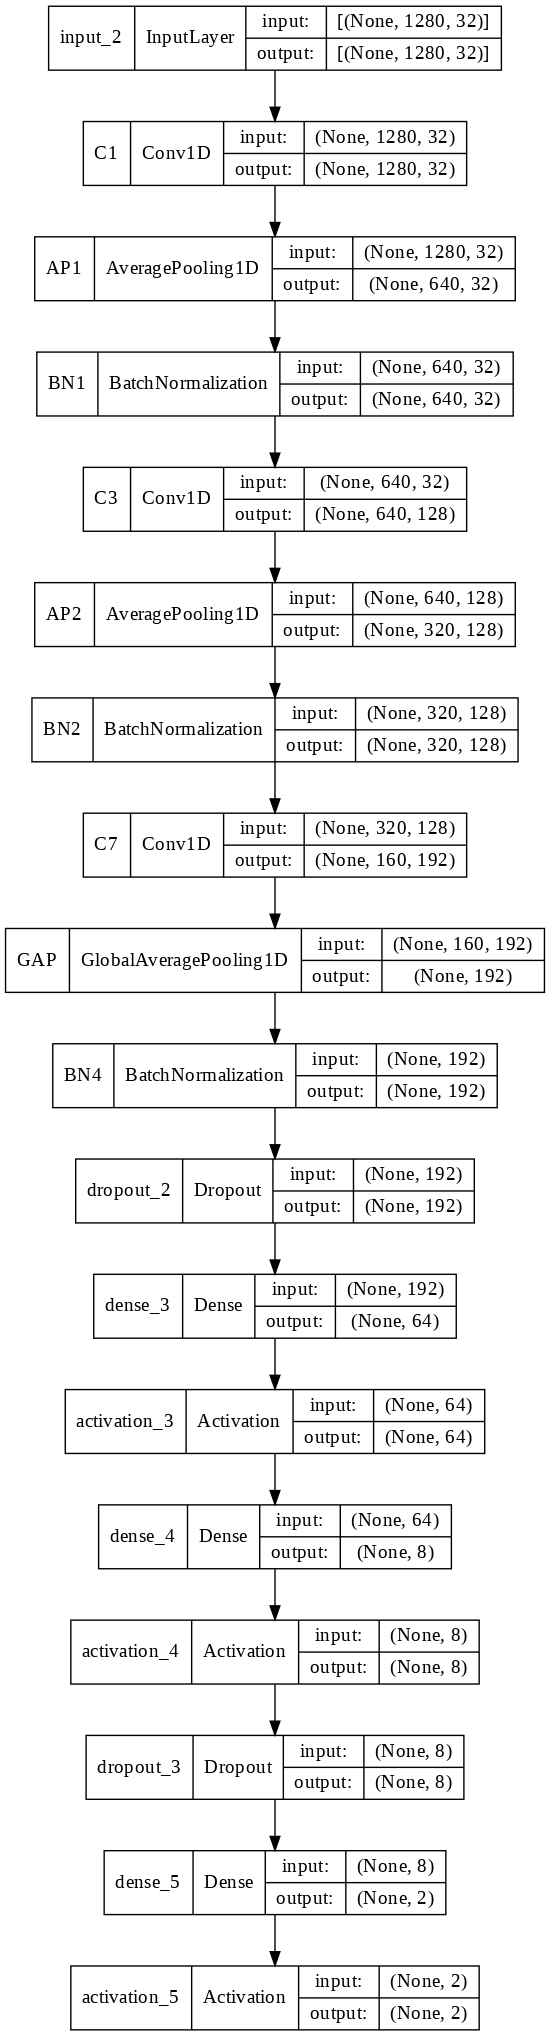

In [8]:
plot_model(model, to_file='DEAP_model.png', show_shapes=True, dpi=100)

## Training and Evaluation

### Valence

####Data Split by using K-fold (here k is 10) Method

In [ ]:
k = 10
nb_samples = data.shape[0] # Number of samples
factor = nb_samples//k # Kth fold by this factor

for i in range(k):
  print('Fold: '+str(i))

  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  val_train = np.concatenate((valence[0 : i*factor], valence[(i+1)*factor : nb_samples])) # Valence training labels
  val_test = valence[i*factor : (i+1)*factor] # Valence testing labels

  # model = get_model()
  # model = CompactNet(input_shape = (window_size, channel_len))
  # model.compile(loss='categorical_crossentropy',
  #             optimizer=Adam(learning_rate=0.001, decay=1e-5),
  #             metrics=['accuracy'])
  model.fit(X_train, val_train, epochs = 5, batch_size = 256, shuffle = True)

  scores = model.evaluate(X_test, val_test)
  print("Test Accuracy: ", str(scores[1]*100))
  
  del X_train, X_test, val_train, val_test


  # yhat = model.predict(X_test)
  # yhatFlat= np.argmax(yhat, axis=1)
  # yFlat = np.argmax(val_test, axis=1)
  
  # actual_cm = confusion_matrix(yhatFlat, yFlat)
  # print('Confusion Matrix:\n',actual_cm)

####Data Split by using Holdout Method

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, valence, test_size=0.2, random_state=random_state)
print('X Training: ',X_train.shape)
print('Y Training: ',Y_train.shape)
print('X Test: ',X_test.shape)
print('Y Test: ',Y_test.shape)
print(type(X_train))

# del data, valence

X Training:  (27648, 1280, 32)
Y Training:  (27648, 2)
X Test:  (6912, 1280, 32)
Y Test:  (6912, 2)
<class 'numpy.ndarray'>


####Training and Evaluation

In [ ]:
batch_size = 512
epochs = 100
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               cooldown=0, patience=10, min_lr=1e-4,
                               factor=0.1, verbose=1)

history = model.fit(X_train, Y_train, epochs=epochs,
          validation_split=0.15,
          batch_size=batch_size,
          shuffle = True,
          verbose=1) #,
          # callbacks=[lr_reducer])

Epoch 1/100
46/46 [==============================] - 7s 73ms/step - loss: 0.7219 - accuracy: 0.5560 - val_loss: 0.7110 - val_accuracy: 0.5499
Epoch 2/100
46/46 [==============================] - 2s 42ms/step - loss: 0.6713 - accuracy: 0.5943 - val_loss: 0.6862 - val_accuracy: 0.5501
Epoch 3/100
46/46 [==============================] - 2s 41ms/step - loss: 0.6523 - accuracy: 0.6150 - val_loss: 0.7011 - val_accuracy: 0.5499
Epoch 4/100
46/46 [==============================] - 2s 42ms/step - loss: 0.6332 - accuracy: 0.6401 - val_loss: 0.7186 - val_accuracy: 0.5504
Epoch 5/100
46/46 [==============================] - 2s 42ms/step - loss: 0.6107 - accuracy: 0.6587 - val_loss: 0.7194 - val_accuracy: 0.5545
Epoch 6/100
46/46 [==============================] - 2s 42ms/step - loss: 0.5962 - accuracy: 0.6763 - val_loss: 0.7034 - val_accuracy: 0.5689
Epoch 7/100
46/46 [==============================] - 2s 42ms/step - loss: 0.5715 - accuracy: 0.6986 - val_loss: 0.6923 - val_accuracy: 0.5781
Epoch 

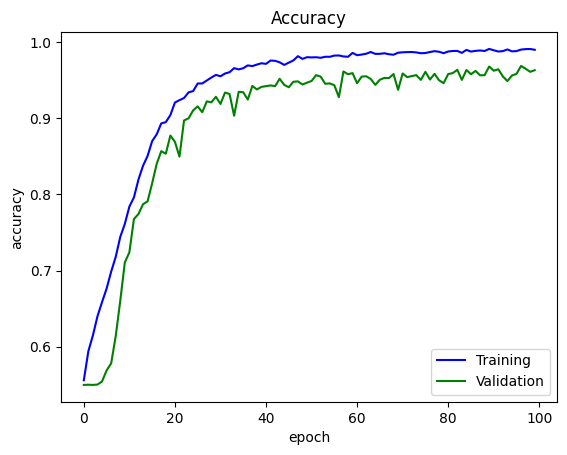

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

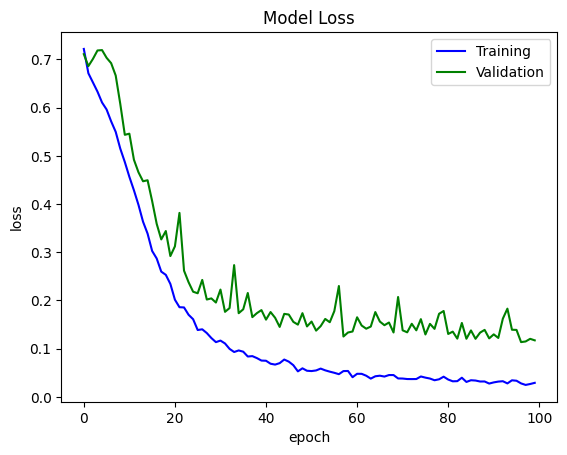

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
# Evaluate the model accuracy on the Test set.
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

216/216 [==============================] - 1s 5ms/step - loss: 0.1226 - accuracy: 0.9647
Test Loss: 0.12255529314279556
Test Accuracy: 96.46990895271301


In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

         Low     0.9656    0.9697    0.9676      3758
        High     0.9637    0.9588    0.9612      3154

    accuracy                         0.9647      6912
   macro avg     0.9646    0.9642    0.9644      6912
weighted avg     0.9647    0.9647    0.9647      6912



Confusion matrix, without normalization
[[3644  130]
 [ 114 3024]]


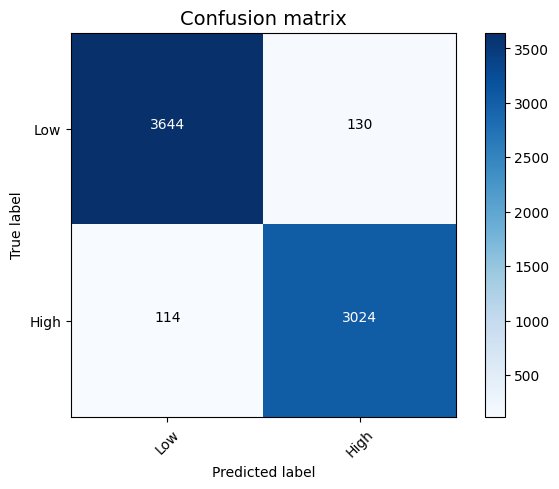

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

Normalized confusion matrix
[[0.96555379 0.03444621]
 [0.03632887 0.96367113]]


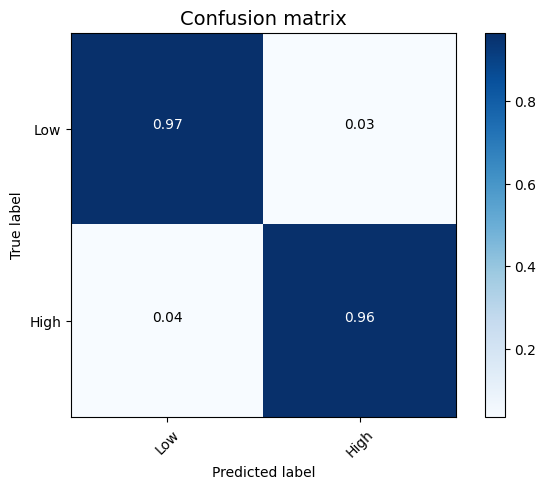

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=True)

### Arousal

####Data Split by using K-fold (here k is 10) Method

In [ ]:
k = 10
nb_samples = data.shape[0] # Number of samples
factor = nb_samples//k # Kth fold by this factor

for i in range(k):
  print('Fold: '+str(i))

  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  val_train = np.concatenate((arousal[0 : i*factor], arousal[(i+1)*factor : nb_samples])) # arousal training labels
  val_test = arousal[i*factor : (i+1)*factor] # arousal testing labels

  model.fit(X_train, val_train, epochs = 5, batch_size = 256, shuffle = True)

  scores = model.evaluate(X_test, val_test)
  print("Test Accuracy: ", str(scores[1]*100))
  
  del X_train, X_test, val_train, val_test


  # yhat = model.predict(X_test)
  # yhatFlat= np.argmax(yhat, axis=1)
  # yFlat = np.argmax(val_test, axis=1)
  
  # actual_cm = confusion_matrix(yhatFlat, yFlat)
  # print('Confusion Matrix:\n',actual_cm)

####Data Split by using Holdout Method

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, arousal, test_size=0.2, random_state=random_state)
print('X Training: ',X_train.shape)
print('Y Training: ',Y_train.shape)
print('X Test: ',X_test.shape)
print('Y Test: ',Y_test.shape)
print(type(X_train))

####Training and Evaluation

In [ ]:
batch_size = 1024
epochs = 100
# lr_reducer = ReduceLROnPlateau(monitor='val_loss',
#                                cooldown=0, patience=10, min_lr=1e-4,
#                                factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs=epochs,
          validation_split=0.15,
          batch_size=batch_size,
          shuffle = True,
          verbose=1) #,
          # callbacks=[lr_reducer])

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
# Evaluate the model accuracy on the Test set.
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=True)

### Dominance

####Data Split by using K-fold (here k is 10) Method

In [ ]:
k = 10
nb_samples = data.shape[0] # Number of samples
factor = nb_samples//k # Kth fold by this factor

for i in range(k):
  print('Fold: '+str(i))

  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  val_train = np.concatenate((dominance[0 : i*factor], dominance[(i+1)*factor : nb_samples])) # dominance training labels
  val_test = dominance[i*factor : (i+1)*factor] # dominance testing labels

  model.fit(X_train, val_train, epochs = 5, batch_size = 256, shuffle = True)

  scores = model.evaluate(X_test, val_test)
  print("Test Accuracy: ", str(scores[1]*100))
  
  del X_train, X_test, val_train, val_test


  # yhat = model.predict(X_test)
  # yhatFlat= np.argmax(yhat, axis=1)
  # yFlat = np.argmax(val_test, axis=1)
  
  # actual_cm = confusion_matrix(yhatFlat, yFlat)
  # print('Confusion Matrix:\n',actual_cm)

####Data Split by using Holdout Method

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, dominance, test_size=0.2, random_state=random_state)
print('X Training: ',X_train.shape)
print('Y Training: ',Y_train.shape)
print('X Test: ',X_test.shape)
print('Y Test: ',Y_test.shape)
print(type(X_train))

####Training and Evaluation

In [ ]:
batch_size = 1024
epochs = 100
# lr_reducer = ReduceLROnPlateau(monitor='val_loss',
#                                cooldown=0, patience=10, min_lr=1e-4,
#                                factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs=epochs,
          validation_split=0.15,
          batch_size=batch_size,
          shuffle = True,
          verbose=1) #,
          # callbacks=[lr_reducer])

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
# Evaluate the model accuracy on the Test set.
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=True)

### Liking

####Data Split by using K-fold (here k is 10) Method

In [ ]:
k = 10
nb_samples = data.shape[0] # Number of samples
factor = nb_samples//k # Kth fold by this factor

for i in range(k):
  print('Fold: '+str(i))

  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  val_train = np.concatenate((liking[0 : i*factor], liking[(i+1)*factor : nb_samples])) # liking training labels
  val_test = liking[i*factor : (i+1)*factor] # liking testing labels

  model.fit(X_train, val_train, epochs = 5, batch_size = 256, shuffle = True)

  scores = model.evaluate(X_test, val_test)
  print("Test Accuracy: ", str(scores[1]*100))
  
  del X_train, X_test, val_train, val_test


  # yhat = model.predict(X_test)
  # yhatFlat= np.argmax(yhat, axis=1)
  # yFlat = np.argmax(val_test, axis=1)
  
  # actual_cm = confusion_matrix(yhatFlat, yFlat)
  # print('Confusion Matrix:\n',actual_cm)

####Data Split by using Holdout Method

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, liking, test_size=0.2, random_state=random_state)
print('X Training: ',X_train.shape)
print('Y Training: ',Y_train.shape)
print('X Test: ',X_test.shape)
print('Y Test: ',Y_test.shape)
print(type(X_train))

####Training and Evaluation

In [ ]:
batch_size = 1024
epochs = 100
# lr_reducer = ReduceLROnPlateau(monitor='val_loss',
#                                cooldown=0, patience=10, min_lr=1e-4,
#                                factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs=epochs,
          validation_split=0.15,
          batch_size=batch_size,
          shuffle = True,
          verbose=1) #,
          # callbacks=[lr_reducer])

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
# Evaluate the model accuracy on the Test set.
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=False)

In [ ]:
actual_cm = confusion_matrix(yhatFlat, yFlat)
plot_confusion_matrix(actual_cm, labels, normalize=True)

#SEED

> Original Shape for Labels:

 1 for positive, 0 for neutral and -1 for negative

label+1 --> 0 negative, 1 neutral, 2 positive

In [2]:
import scipy.io as sio 
import numpy as np
import os
import warnings
import itertools
import matplotlib.pyplot as plt
                                                  
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import (Activation, AveragePooling1D, Dense, Conv1D, Flatten, Dropout, Input, BatchNormalization,
                                     GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model, to_categorical

warnings.filterwarnings("ignore")
plt.rcdefaults()

dir_path = "/content/ExtractedFeatures"
classes = 3

labels = ['Negative', 'Neutral', 'Positive'] #NEG:0 NE:1 POS:2

##Confusion Matrix

In [ ]:
def plot_confusion_matrix(X_test, Y_test, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    truey=[]
    predy=[]

    y = Y_test
    yhat= model.predict(X_test)
    yh = yhat.tolist()
    yt = y.tolist()

    count = 0
    for i in range(len(y)):
        yy = max(yh[i])
        yyt = max(yt[i])
        predy.append(yh[i].index(yy))
        truey.append(yt[i].index(yyt))
        if(yh[i].index(yy)== yt[i].index(yyt)):
            count+=1


    acc = (count/len(y))*100
    print("Accuracy on test set: "+str(acc)+"%")

    cm = confusion_matrix(truey, predy)
    print(cm)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm = confusion_matrix(truey, predy)
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Loading Data

###Unzipping

In [ ]:
!unzip /content/drive/MyDrive/ExtractedFeatures.zip

Archive:  /content/drive/MyDrive/ExtractedFeatures.zip
   creating: ExtractedFeatures/
 extracting: ExtractedFeatures/15_20131105.mat  
 extracting: ExtractedFeatures/15_20131016.mat  
 extracting: ExtractedFeatures/15_20130709.mat  
 extracting: ExtractedFeatures/14_20140627.mat  
 extracting: ExtractedFeatures/14_20140615.mat  
 extracting: ExtractedFeatures/14_20140601.mat  
 extracting: ExtractedFeatures/13_20140610.mat  
 extracting: ExtractedFeatures/13_20140603.mat  
 extracting: ExtractedFeatures/13_20140527.mat  
 extracting: ExtractedFeatures/12_20131207.mat  
 extracting: ExtractedFeatures/12_20131201.mat  
 extracting: ExtractedFeatures/12_20131127.mat  
 extracting: ExtractedFeatures/11_20140630.mat  
 extracting: ExtractedFeatures/11_20140625.mat  
 extracting: ExtractedFeatures/11_20140618.mat  
 extracting: ExtractedFeatures/10_20131211.mat  
 extracting: ExtractedFeatures/10_20131204.mat  
 extracting: ExtractedFeatures/10_20131130.mat  
 extracting: ExtractedFeatures/

###Loading and Pre-processing SEED Dataset
Since each frequency band signal has 62 channels, we
extracted differential entropy features with 310 dimensions for a sample (i.e., 62x5=310)
> Feature Types: 

1.   differential entropy (DE)
2.   differential asymmetry (DASM)
3.   rational asymmetry (RASM)

> Feature Smoothing Methods

1.   moving average
2.   linear dynamic systems (LDS)

In [ ]:
feature_types = ["de", "psd", "dasm", "rasm", "asm", "dcau"]
# feature_types = ["de", "psd"]

smooth_method_types = ["movingAve", "LDS"]

label_path = os.path.join(dir_path, "label.mat")
labels = sio.loadmat(label_path)["label"][0]
labels += 1

num_of_subjects = 15
num_of_experiment = 15
for feature_type in feature_types:
    for smooth_method_type in smooth_method_types:
        folder_name = os.path.join(dir_path, feature_type +"_" + smooth_method_type)
        print("folder name: ", folder_name)
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        stacked_arr = None
        stacked_label = None
        cumulative_samples = [0]
        for i in range(num_of_subjects):
            print("Subject {} / {}".format(i+1, num_of_subjects))
            for trial_path in os.listdir(dir_path):
                if trial_path.startswith(str(i+1) + "_"):  # trial record for the Subject
                    feature2dict= sio.loadmat(os.path.join(dir_path, trial_path))
                    for experiment_index in range(num_of_experiment):
                        k = feature_type + "_" + smooth_method_type + str(experiment_index+1)
                        v = feature2dict[k]
                        # print(v.shape)  # (62, 235, 5) for example
                        temp_arr = np.swapaxes(v, 0, 1).reshape(v.shape[1], -1)    
                        num_of_samples = temp_arr.shape[0]   
                        cumulative_samples.append(cumulative_samples[-1] + num_of_samples)
                        temp_labels = np.ones((num_of_samples, 1)) * labels[experiment_index]          
                        # print(temp_arr.shape)  # (235, 310) for example
                        if stacked_arr is None:
                            stacked_arr = temp_arr.copy()
                            stacked_label = temp_labels.copy()
                        else:
                            stacked_arr = np.vstack((stacked_arr, temp_arr))
                            stacked_label = np.vstack((stacked_label, temp_labels))
        print("feature shape:", stacked_arr.shape)
        print("label shape: ", stacked_label.shape)
        cumulative_sample_arr = np.array(cumulative_samples)
        print("cumulative sample shape: ", cumulative_sample_arr.shape)
        feature_path = os.path.join(folder_name, "feature.npy")
        label_path = os.path.join(folder_name, "label.npy")
        cumulative_samples_path = os.path.join(folder_name, "cumulative.npy")
        print("saving feature.npy and label.npy to folder {}".format(folder_name))
        np.save(feature_path, stacked_arr)
        np.save(label_path, stacked_label)
        np.save(cumulative_samples_path, cumulative_sample_arr)

folder name:  /content/ExtractedFeatures/de_movingAve
Subject 1 / 15
Subject 2 / 15
Subject 3 / 15
Subject 4 / 15
Subject 5 / 15
Subject 6 / 15
Subject 7 / 15
Subject 8 / 15
Subject 9 / 15
Subject 10 / 15
Subject 11 / 15
Subject 12 / 15
Subject 13 / 15
Subject 14 / 15
Subject 15 / 15
feature shape: (152730, 310)
label shape:  (152730, 1)
cumulative sample shape:  (676,)
saving feature.npy and label.npy to folder /content/ExtractedFeatures/de_movingAve
folder name:  /content/ExtractedFeatures/de_LDS
Subject 1 / 15
Subject 2 / 15
Subject 3 / 15
Subject 4 / 15
Subject 5 / 15
Subject 6 / 15
Subject 7 / 15
Subject 8 / 15
Subject 9 / 15
Subject 10 / 15
Subject 11 / 15
Subject 12 / 15
Subject 13 / 15
Subject 14 / 15
Subject 15 / 15
feature shape: (152730, 310)
label shape:  (152730, 1)
cumulative sample shape:  (676,)
saving feature.npy and label.npy to folder /content/ExtractedFeatures/de_LDS
folder name:  /content/ExtractedFeatures/psd_movingAve
Subject 1 / 15
Subject 2 / 15
Subject 3 / 15


## CNN Model

In [3]:
def CompactNet(input_shape, weightsPath=None):
    
    X_input = Input(input_shape)
    x = Conv1D(32, kernel_size = 2, strides = 1, padding = 'same', activation='relu', name='C1')(X_input)
    x = AveragePooling1D(pool_size=2, name='AP1')(x)
    x = BatchNormalization(name='BN1')(x)

    x = Conv1D(128, kernel_size = 5, strides = 1, padding = 'same', activation='relu', name='C3')(x)
    x = AveragePooling1D(pool_size=2, name='AP2')(x)
    x = BatchNormalization(name='BN2')(x)

    x = Conv1D(192, kernel_size = 3, strides = 2, padding = 'same', activation='relu', name='C7')(x)
    x = GlobalAveragePooling1D(name='GAP')(x)
    x = BatchNormalization(name='BN4')(x)

    x = Dropout(0.2)(x)
    x = Dense(64)(x)
    x = Activation('tanh')(x)
    x = Dense(8)(x)
    x = Activation('tanh')(x)
    x = Dropout(0.1)(x)
    x = Dense(classes)(x)
    output = Activation('softmax')(x)

    model=Model(inputs=X_input, outputs=output, name='CompactNet')

    if weightsPath is not None:
        model.load_weights(weightsPath)

    return model

model = CompactNet(input_shape = (310, 1))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

Model: "CompactNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 310, 1)]          0         
                                                                 
 C1 (Conv1D)                 (None, 310, 32)           96        
                                                                 
 AP1 (AveragePooling1D)      (None, 155, 32)           0         
                                                                 
 BN1 (BatchNormalization)    (None, 155, 32)           128       
                                                                 
 C3 (Conv1D)                 (None, 155, 128)          20608     
                                                                 
 AP2 (AveragePooling1D)      (None, 77, 128)           0         
                                                                 
 BN2 (BatchNormalization)    (None, 77, 128)           5

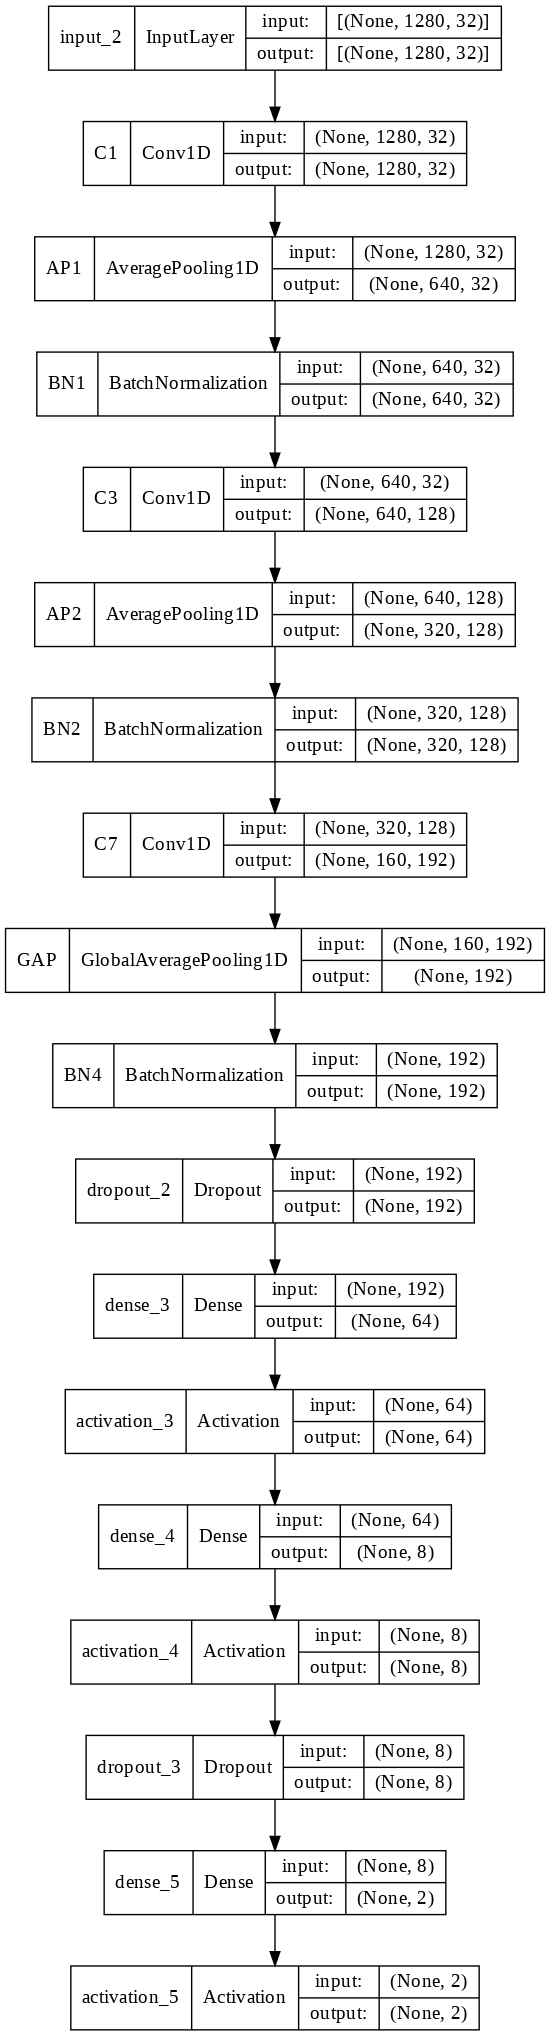

In [9]:
plot_model(model, to_file='SEED_model.png', show_shapes=True, dpi=100)

## Training and Evaluation

In [ ]:
temp_dir = "/content/ExtractedFeatures/de_movingAve"

def load_mat(dirname):
    feature_arr = np.load(os.path.join(dirname, "feature.npy"))
    label_arr = np.load(os.path.join(dirname, "label.npy"))
    cumulative_arr = np.load(os.path.join(dirname, "cumulative.npy"))
    return feature_arr, label_arr, cumulative_arr

feature, label, cumulative = load_mat(temp_dir)

np.save("/content/drive/MyDrive/Data_and_labels/SEED/feature",feature)
np.save("/content/drive/MyDrive/Data_and_labels/SEED/label",label)

In [ ]:

scaler = StandardScaler().fit(feature)
feature_scaled = scaler.transform(feature)
data = feature_scaled.reshape(-1, 310, 1).astype('float32')
lab = to_categorical(label, num_classes=3)
X_train, X_test, Y_train, Y_test = train_test_split(data, lab, test_size=0.1, random_state=100)

In [ ]:
batch_size = 512
epochs = 100
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               cooldown=0, patience=10, min_lr=1e-7,
                               factor=0.1, verbose=1)
history = model.fit(X_train, Y_train, epochs=epochs,
          validation_split=0.15,
          batch_size=batch_size,
          shuffle = True,
          verbose=1,
          callbacks=[lr_reducer])

Epoch 1/100
229/229 [==============================] - 6s 19ms/step - loss: 0.5275 - accuracy: 0.7817 - val_loss: 0.6778 - val_accuracy: 0.7039 - lr: 1.0000e-04
Epoch 2/100
229/229 [==============================] - 4s 18ms/step - loss: 0.4817 - accuracy: 0.8035 - val_loss: 0.6286 - val_accuracy: 0.7299 - lr: 1.0000e-04
Epoch 3/100
229/229 [==============================] - 4s 18ms/step - loss: 0.4666 - accuracy: 0.8111 - val_loss: 0.5807 - val_accuracy: 0.7577 - lr: 1.0000e-04
Epoch 4/100
229/229 [==============================] - 4s 18ms/step - loss: 0.4474 - accuracy: 0.8211 - val_loss: 0.5504 - val_accuracy: 0.7737 - lr: 1.0000e-04
Epoch 5/100
229/229 [==============================] - 4s 18ms/step - loss: 0.4348 - accuracy: 0.8266 - val_loss: 0.5056 - val_accuracy: 0.7949 - lr: 1.0000e-04
Epoch 6/100
229/229 [==============================] - 4s 18ms/step - loss: 0.4225 - accuracy: 0.8323 - val_loss: 0.4828 - val_accuracy: 0.8045 - lr: 1.0000e-04
Epoch 7/100
229/229 [=============

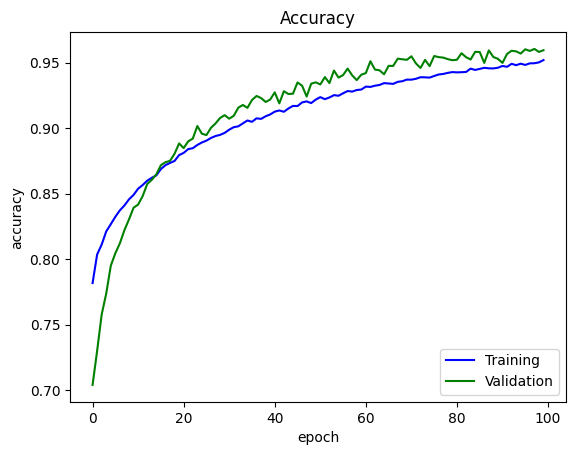

In [ ]:
plt.plot(history.history['accuracy'], 'b', label='Training')
plt.plot(history.history['val_accuracy'], 'g', label='Validation')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('acc_plot',dpi=100)
plt.show()

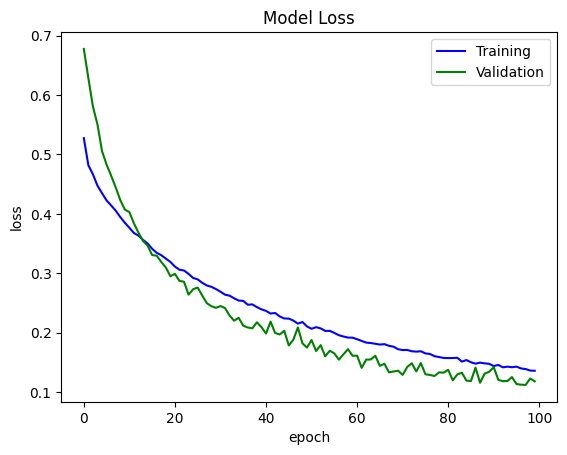

In [ ]:
plt.plot(history.history['loss'], 'b', label='Training')
plt.plot(history.history['val_loss'], 'g', label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('loss_plot',dpi=100)
plt.show()

In [ ]:
# Evaluate the model accuracy on the Test set.
scores = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: " + str(scores[0]))
print("Test Accuracy: " + str(scores[1]*100))

478/478 [==============================] - 2s 3ms/step - loss: 0.1118 - accuracy: 0.9614
Test Loss: 0.11175063252449036
Test Accuracy: 96.13697528839111


In [ ]:
yFlat = np.argmax(Y_test, axis=1)
yhat = model.predict(X_test)
yhatFlat= np.argmax(yhat, axis=1)
print(classification_report(yFlat, yhatFlat, target_names=labels, digits=4))

              precision    recall  f1-score   support

    Negative     0.9540    0.9584    0.9562      5102
     Neutral     0.9518    0.9568    0.9543      4933
    Positive     0.9778    0.9685    0.9731      5238

    accuracy                         0.9614     15273
   macro avg     0.9612    0.9613    0.9612     15273
weighted avg     0.9615    0.9614    0.9614     15273



Accuracy on test set: 96.13697374451647%
[[4890  161   51]
 [ 149 4720   64]
 [  87   78 5073]]
Normalized confusion matrix


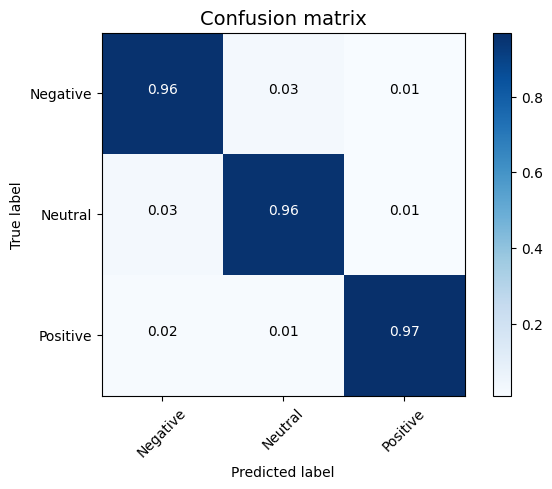

In [ ]:
plot_confusion_matrix(X_test, Y_test, labels, normalize=True)